In [2]:
import os
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
import shap
from tqdm import tqdm

# cluster 2

In [4]:
# Lista dei soggetti di interesse
subjects_of_interest = [
    'SRR2143826', 'ERR475551', 'SRR2143710', 'SRR2143695', 
    'Adenoma12-2799', 'SRR2144035', 'ERR475587', 
    'SRR2143942', 'SRR2143890', 'SRR2143950', 'Adenoma16-2873'
]

# Caricamento dati
df = pd.read_csv('df.csv', index_col=0)
metadata = pd.read_csv('metadata.csv').set_index('SampleID')

# Preprocessing dei dati
df['Gender_m'] = df['Gender_m'].astype(int)
df['Country_CA'] = df['Country_CA'].astype(int)
df['Country_FRA'] = df['Country_FRA'].astype(int)
df['Country_USA'] = df['Country_USA'].astype(int)
df = df.dropna()
metadata = metadata.loc[df.index]

X = df.iloc[:, :-1]  # Features
y = (metadata['Diagnosis'] == 'Cancer').astype(int)  # Target

# Impostazioni Cross-Validation
np.random.seed(42)
cv_repeats = 20
random_states = np.random.randint(10000, size=cv_repeats)


# Calcolo dei valori di interazione SHAP per i soggetti di interesse
shap_interaction_values_interest = pd.DataFrame(0, index=X.columns, columns=X.columns)
fold_count_interest = 0

# Filtrare X per i soggetti di interesse
X_interest = X.loc[subjects_of_interest]

# Impostazioni Cross-Validation
for repeat, random_state in enumerate(tqdm(random_states, desc="Repeats")):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(X, y), desc=f"Repeat {repeat + 1}", leave=False, total=5)):
        # Training e test split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Modello CatBoost
        model = CatBoostClassifier(random_state=42, verbose=0)
        model.fit(X_train, y_train)

        # Calcolo dei valori di interazione SHAP solo per i soggetti di interesse
        explainer = shap.TreeExplainer(model)
        shap_interaction_values = explainer.shap_interaction_values(X_interest)

        # Accumulare i valori di interazione
        shap_interaction_values_interest += np.abs(shap_interaction_values).mean(axis=0)
        fold_count_interest += 1

# Calcolo della media dei valori di interazione SHAP
shap_interaction_values_interest /= fold_count_interest

# Creare un nuovo file per salvare i risultati
new_save_path = "shap_interaction_results_cluster2"
os.makedirs(new_save_path, exist_ok=True)

# Funzione per salvare i risultati con un nome diverso
def save_shap_interactions_interest(shap_interaction_values_avg, columns, save_path):
    # Assicurarsi che shap_interaction_values_avg sia una matrice quadrata
    interaction_df = pd.DataFrame(
        shap_interaction_values_avg,
        index=columns,
        columns=columns
    )

    # Convertire i valori di interazione in un formato lungo
    interaction_long = []
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            interaction_long.append([
                columns[i], columns[j], interaction_df.iloc[i, j]
            ])
    
    interaction_long_df = pd.DataFrame(
        interaction_long, columns=['Feature1', 'Feature2', 'Interaction']
    )
    interaction_long_df = interaction_long_df.sort_values(by='Interaction', ascending=False)

    # Salvare i risultati
    interaction_long_df.to_csv(os.path.join(save_path, 'shap_interaction_values_cluster2_long.csv'), index=False)
    interaction_df.to_csv(os.path.join(save_path, 'shap_interaction_values_cluster2_matrix.csv'))

    return interaction_long_df

# Salvare i risultati
save_shap_interactions_interest(shap_interaction_values_interest, X.columns, new_save_path)

print("Valori di interazione SHAP per i soggetti di interesse salvati con successo.")


Repeats: 100%|█████████████████████████████████| 20/20 [34:58<00:00, 104.93s/it]

Valori di interazione SHAP per i soggetti di interesse salvati con successo.


In [5]:
shap_long=pd.read_csv('shap_interaction_results_cluster2/shap_interaction_values_cluster2_long.csv')
shap_long

,Feature1,Feature2,Interaction
0,Odoribacter,Peptostreptococcus,0.009361
1,Akkermansia,Peptostreptococcus,0.009170
2,Peptostreptococcus,CAG-56,0.008065
3,Fusobacterium,Akkermansia,0.006493
4,NK4A214_group,Peptostreptococcus,0.005973
...,...,...,...
14360,Butyricimonas,Country_FRA,0.000000
14361,Izemoplasmatales,Gender_m,0.000000
14362,Paracoccus,Country_FRA,0.000000
14363,Streptococcus,Country_FRA,0.000000


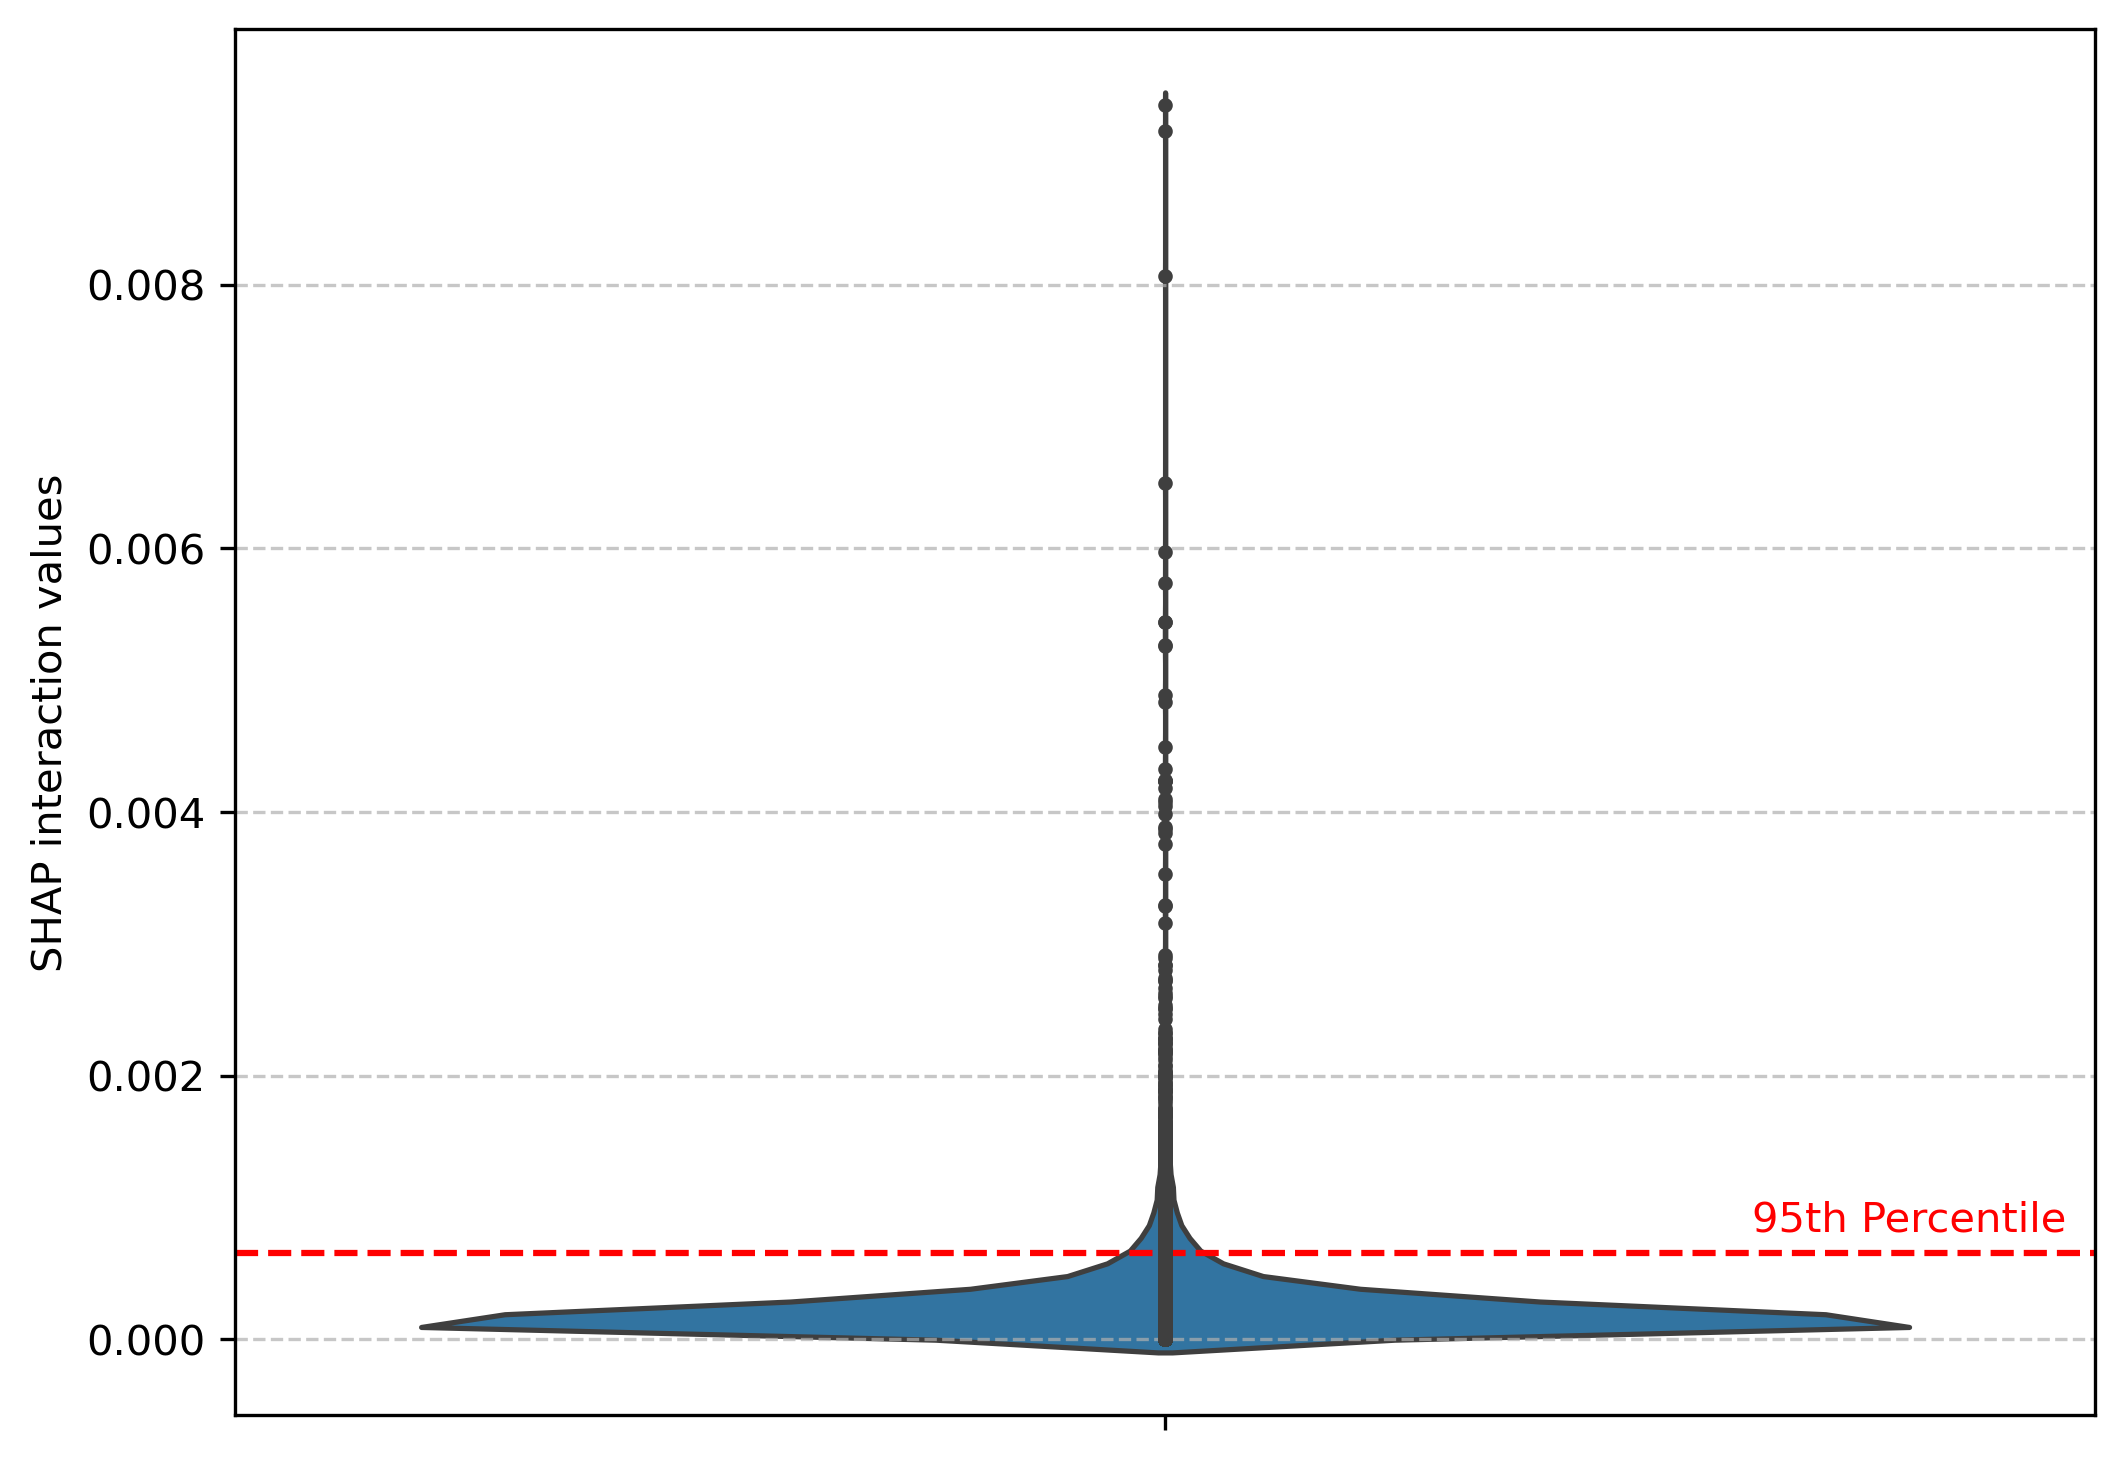

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creazione del violin plot
plt.figure(figsize=(8, 6), dpi=300)
sns.violinplot(y='Interaction', data=shap_long, inner='point')

# Aggiunta della linea al 95° percentile
percentile = shap_long['Interaction'].quantile(0.95)
plt.axhline(y=percentile, color='red', linestyle='--', label='95° Percentile')

# Aggiunta del testo sulla linea
plt.text(
    x=0.4, 
    y=percentile + 0.0001,  # Posizione leggermente sopra la linea
    s='95th Percentile', 
    color='red', 
    fontsize=10, 
    ha='center', 
    va='bottom'
)

plt.title('')
plt.xlabel('')
plt.ylabel('SHAP interaction values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


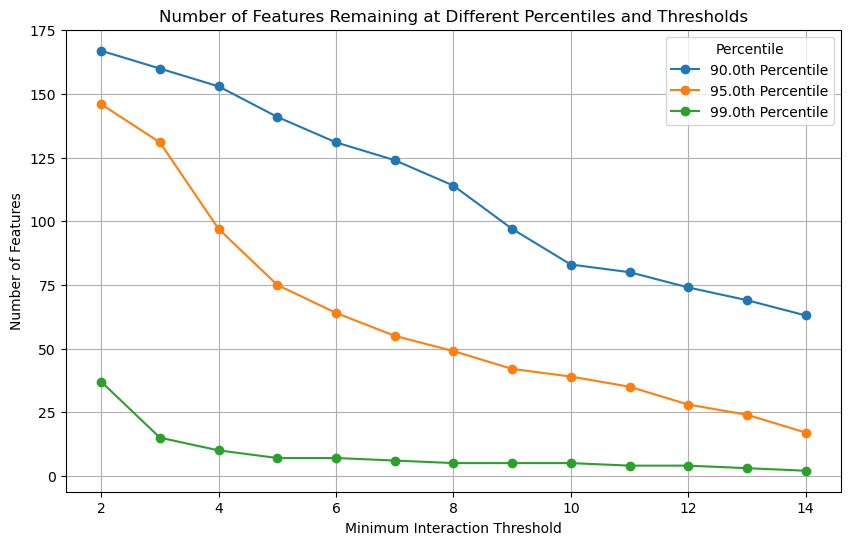

,Feature,Count
0,Peptostreptococcus,158
1,Fusobacterium,93
2,Parvimonas,89
3,Porphyromonas,89
4,BMI,58
5,Lachnospiraceae_UCG-010,35
6,Akkermansia,28
7,NK4A214_group,23
8,Marvinbryantia,17
9,CAG-352,16


In [7]:
# Initialize variables for thresholds and counts
percentiles = [0.90, 0.95, 0.99]
thresholds = range(2, 15)  # Minimum interaction count
result_matrix = []

# Iterate over percentiles and thresholds
for percentile in percentiles:
    threshold_value = shap_long["Interaction"].quantile(percentile)
    shap_filtered = shap_long[shap_long["Interaction"] >= threshold_value]

    interaction_counts = pd.concat([
        shap_filtered["Feature1"],
        shap_filtered["Feature2"]
    ]).value_counts()

    for threshold in thresholds:
        filtered_count = interaction_counts[interaction_counts >= threshold].shape[0]
        result_matrix.append({"Percentile": percentile, "Threshold": threshold, "Count": filtered_count})

# Convert results to a DataFrame
result_df = pd.DataFrame(result_matrix)

# Plot the results
plt.figure(figsize=(10, 6))
for percentile in percentiles:
    subset = result_df[result_df["Percentile"] == percentile]
    plt.plot(subset["Threshold"], subset["Count"], marker="o", label=f"{percentile*100}th Percentile")

plt.xlabel("Minimum Interaction Threshold")
plt.ylabel("Number of Features")
plt.title("Number of Features Remaining at Different Percentiles and Thresholds")
plt.legend(title="Percentile")
plt.grid(True)
plt.show()

# Filtered Interaction Counts for the final configuration
final_percentile = 0.95
final_threshold = 10

threshold_value_final = shap_long["Interaction"].quantile(final_percentile)
shap_filtered_final = shap_long[shap_long["Interaction"] >= threshold_value_final]

interaction_counts_final = pd.concat([
    shap_filtered_final["Feature1"],
    shap_filtered_final["Feature2"]
]).value_counts()

filtered_interaction_counts_final = interaction_counts_final[interaction_counts_final >= final_threshold]

# Display the final filtered interaction counts
filtered_interaction_counts_final.reset_index(name='Count').rename(columns={'index': 'Feature'})

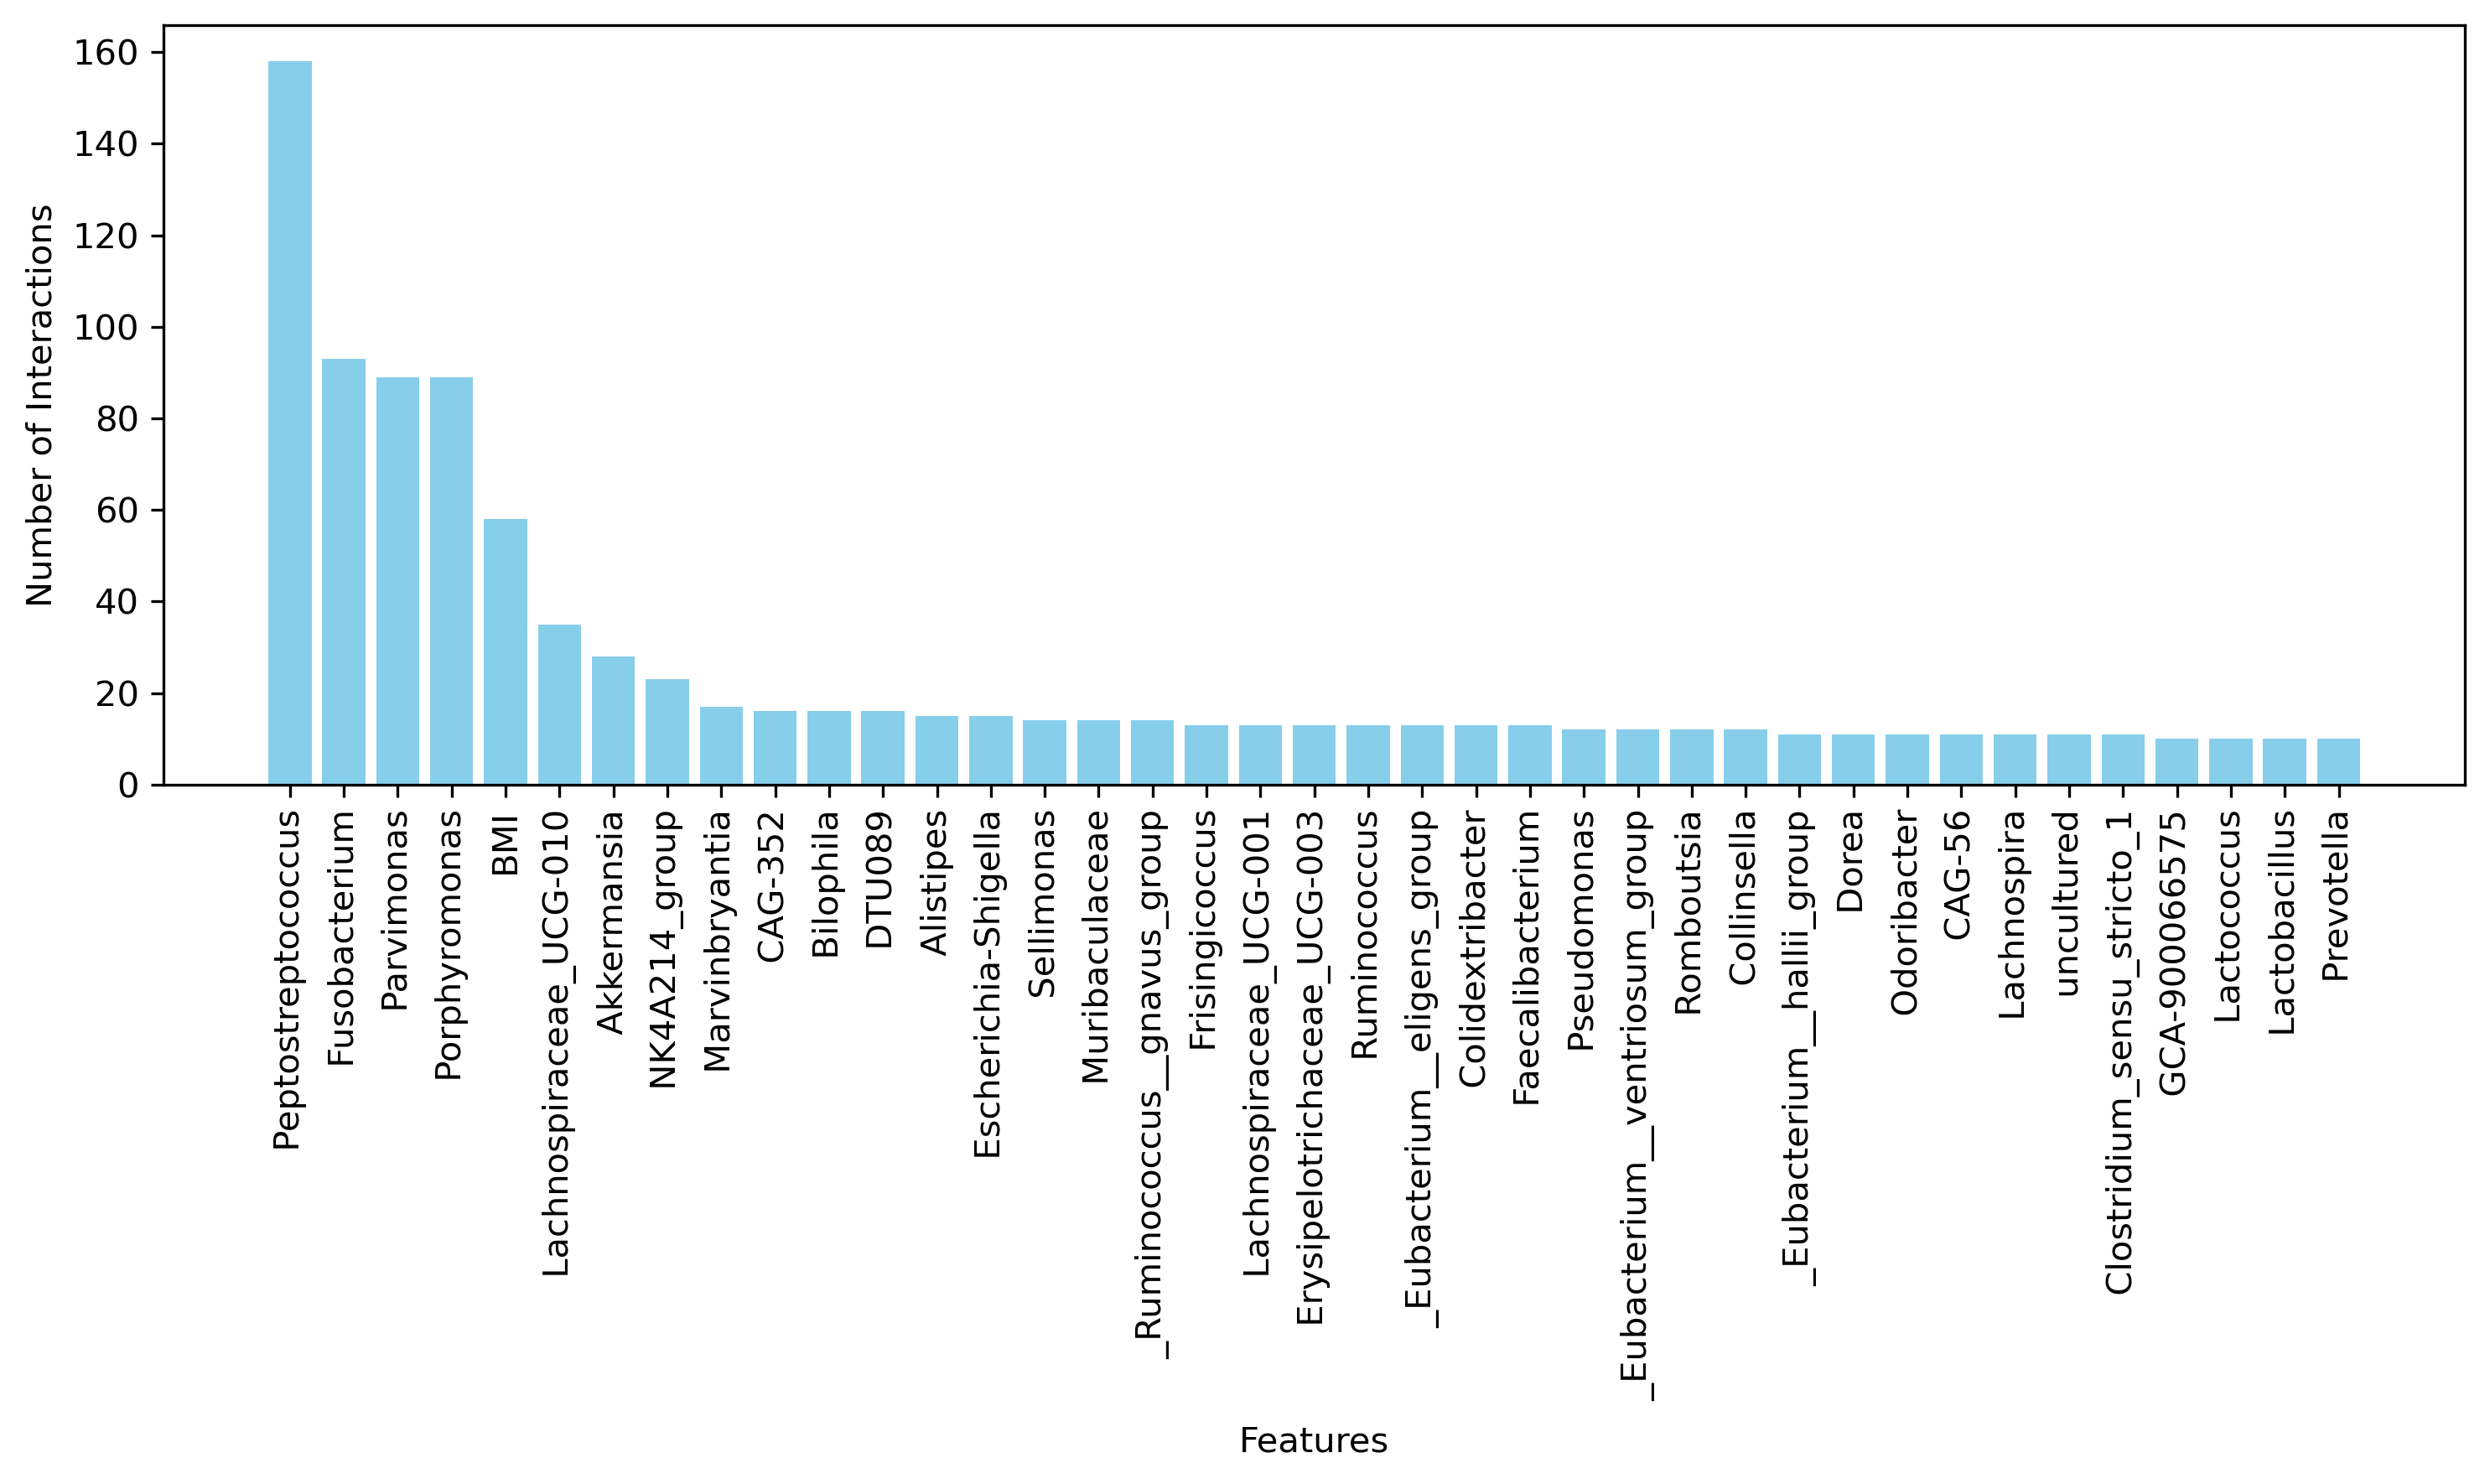

In [8]:
# Prepare the filtered interaction counts DataFrame
filtered_interaction_counts_df = (
    filtered_interaction_counts_final
    .reset_index(name='Count')
    .rename(columns={'index': 'Feature'})
)

# Plot the histogram of the 'Count' column
plt.figure(figsize=(10, 6),dpi=300)
plt.bar(
    filtered_interaction_counts_df['Feature'], 
    filtered_interaction_counts_df['Count'], 
    color='skyblue'
)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Number of Interactions")
plt.title("")
plt.tight_layout()
plt.show()

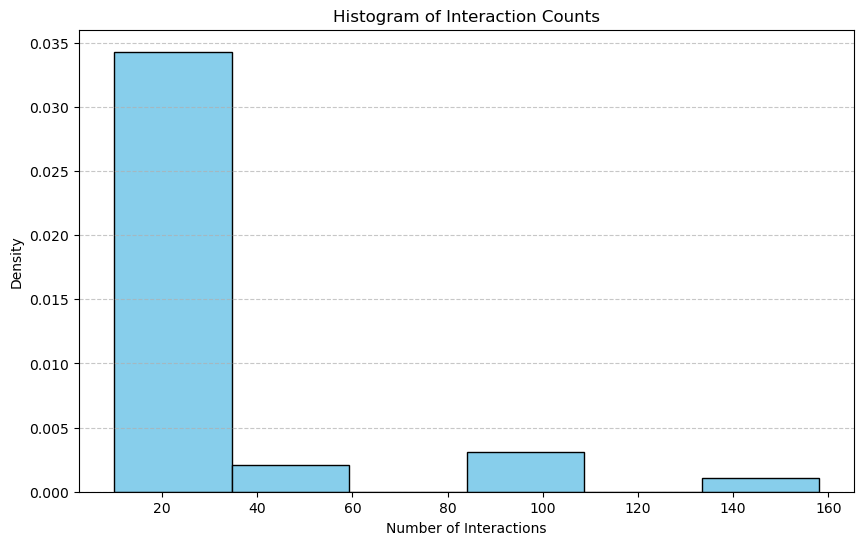

In [9]:
# Plotting the histogram of the 'Count' column
plt.figure(figsize=(10, 6))
plt.hist(filtered_interaction_counts_df['Count'], bins=6, color='skyblue', density =True,edgecolor='black')
plt.xlabel("Number of Interactions")
plt.ylabel("Density")
plt.title("Histogram of Interaction Counts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [10]:
# Selezione del 95° percentile del dataframe basandosi sulla colonna 'Interaction'
threshold_95 = shap_long['Interaction'].quantile(0.95)
shap_long_95_percentile = shap_long[shap_long['Interaction'] >= threshold_95]
shap_long_95_percentile

,Feature1,Feature2,Interaction
0,Odoribacter,Peptostreptococcus,0.009361
1,Akkermansia,Peptostreptococcus,0.009170
2,Peptostreptococcus,CAG-56,0.008065
3,Fusobacterium,Akkermansia,0.006493
4,NK4A214_group,Peptostreptococcus,0.005973
...,...,...,...
714,_Ruminococcus__gauvreauii_group,Clostridia_UCG-014,0.000659
715,NK4A214_group,Oscillibacter,0.000659
716,RF39,_Eubacterium__ventriosum_group,0.000658
717,_Eubacterium__hallii_group,BMI,0.000658


In [11]:
# Calcolare il numero di interazioni sopra il 95° percentile per ciascuna feature
# Combinare le colonne Feature1 e Feature2 in un unico array, poi contare le occorrenze
interaction_counts = pd.concat([
    shap_long_95_percentile['Feature1'], 
    shap_long_95_percentile['Feature2']
]).value_counts()

# Convertire in un DataFrame per una rappresentazione più leggibile
interaction_counts_df = interaction_counts.reset_index()
interaction_counts_df.columns = ['Feature', 'Count']

# Ordinare il DataFrame in base al numero di interazioni
interaction_counts_df = interaction_counts_df.sort_values(by='Count', ascending=False)

# Mostrare i risultati
print(interaction_counts_df)

                 Feature  Count
0     Peptostreptococcus    158
1          Fusobacterium     93
2             Parvimonas     89
3          Porphyromonas     89
4                    BMI     58
..                   ...    ...
149       Intestinimonas      1
148              Slackia      1
147          Allisonella      1
146          Peptococcus      1
163            UC5-1-2E3      1

[164 rows x 2 columns]


In [12]:
# Definire una soglia minima di interazioni
interaction_threshold = 10

# Filtrare il DataFrame per mantenere solo le righe che superano la soglia
filtered_interaction_counts_df = interaction_counts_df[interaction_counts_df['Count'] >= interaction_threshold]

# Mostrare il sotto-DataFrame
print(filtered_interaction_counts_df)


                            Feature  Count
0                Peptostreptococcus    158
1                     Fusobacterium     93
2                        Parvimonas     89
3                     Porphyromonas     89
4                               BMI     58
5           Lachnospiraceae_UCG-010     35
6                       Akkermansia     28
7                     NK4A214_group     23
8                    Marvinbryantia     17
11                           DTU089     16
10                        Bilophila     16
9                           CAG-352     16
12                        Alistipes     15
13             Escherichia-Shigella     15
14                       Sellimonas     14
15                   Muribaculaceae     14
16      _Ruminococcus__gnavus_group     14
20                     Ruminococcus     13
23                 Faecalibacterium     13
21      _Eubacterium__eligens_group     13
22                 Colidextribacter     13
19      Erysipelotrichaceae_UCG-003     13
18         

In [13]:
# Definire una soglia minima di interazioni
interaction_threshold = 10

# Filtrare le feature che superano la soglia
features_above_threshold = interaction_counts_df[interaction_counts_df['Count'] >= interaction_threshold]['Feature']

# Creare un sotto-dataframe che contiene solo le interazioni tra queste feature
filtered_shap_long = shap_long_95_percentile[
    (shap_long_95_percentile['Feature1'].isin(features_above_threshold)) &
    (shap_long_95_percentile['Feature2'].isin(features_above_threshold))
].reset_index(drop=True)

# Mostrare il sotto-dataframe
filtered_shap_long

,Feature1,Feature2,Interaction
0,Odoribacter,Peptostreptococcus,0.009361
1,Akkermansia,Peptostreptococcus,0.009170
2,Peptostreptococcus,CAG-56,0.008065
3,Fusobacterium,Akkermansia,0.006493
4,NK4A214_group,Peptostreptococcus,0.005973
...,...,...,...
258,Collinsella,Lactococcus,0.000664
259,Parvimonas,CAG-56,0.000664
260,Erysipelotrichaceae_UCG-003,Odoribacter,0.000662
261,CAG-352,Lachnospiraceae_UCG-010,0.000661


In [15]:
import networkx as nx
# Ensure 'Count' is numeric
filtered_interaction_counts_df['Count'] = pd.to_numeric(filtered_interaction_counts_df['Count'], errors='coerce')

# Check if there are any NaN values
if filtered_interaction_counts_df['Count'].isna().any():
    print("Found NaN values in 'Count'. Dropping these rows.")
    filtered_interaction_counts_df = filtered_interaction_counts_df.dropna(subset=['Count'])

# Convert 'Count' to integer type
filtered_interaction_counts_df['Count'] = filtered_interaction_counts_df['Count'].astype(int)

# Define size classes and assign sizes
size_classes = [100, 250, 500, 1000]  # Adjust node size ranges for visualization
filtered_interaction_counts_df['Size'] = pd.cut(
    filtered_interaction_counts_df['Count'].values, 
    bins=4, 
    labels=size_classes
)

# Build the graph
G = nx.Graph()

# Add nodes with size (proportional to 'Count')
for _, row in filtered_interaction_counts_df.iterrows():
    G.add_node(row['Feature'], size=int(row['Size']))

# Add edges with weights
for _, row in filtered_shap_long.iterrows():
    G.add_edge(row['Feature1'], row['Feature2'], weight=row['Interaction'])


/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_17743/3885507600.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interaction_counts_df['Count'] = pd.to_numeric(filtered_interaction_counts_df['Count'], errors='coerce')
/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_17743/3885507600.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interaction_counts_df['Count'] = filtered_interaction_counts_df['Count'].astype(int)
/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/

In [16]:
# Print edges with weights
print("Edges with weights:")
for u, v, data in G.edges(data=True):
    print(f"{u} -- {v}, weight: {data['weight']}")


Edges with weights:
 Peptostreptococcus --  Odoribacter, weight: 0.0093608777535811
 Peptostreptococcus --  Akkermansia, weight: 0.0091700691326334
 Peptostreptococcus --  CAG-56, weight: 0.0080648031324871
 Peptostreptococcus --  NK4A214_group, weight: 0.005972973478648
 Peptostreptococcus --  Clostridium_sensu_stricto_1, weight: 0.0054384487388427
 Peptostreptococcus --  Lactobacillus, weight: 0.0052699227630963
 Peptostreptococcus --  Porphyromonas, weight: 0.0048881257683378
 Peptostreptococcus --  Alistipes, weight: 0.004835545604893
 Peptostreptococcus --  Pseudomonas, weight: 0.0043281653490473
 Peptostreptococcus -- BMI, weight: 0.0042350125847044
 Peptostreptococcus --  Parvimonas, weight: 0.004186287264073
 Peptostreptococcus --  Fusobacterium, weight: 0.0041001731543772
 Peptostreptococcus --  Romboutsia, weight: 0.004078912045629
 Peptostreptococcus --  Bilophila, weight: 0.0038418556350892
 Peptostreptococcus --  Lactococcus, weight: 0.0027169419745427
 Peptostreptococcus 

In [17]:
# Save the edges dataframe with source, target, and weight
edges_df = filtered_shap_long[['Feature1', 'Feature2', 'Interaction']].rename(
    columns={'Feature1': 'Source', 'Feature2': 'Target', 'Interaction': 'Weight'}
)
edges_df.to_csv("edges_cluster2.csv", index=False)

In [18]:
# Calcolare varie metriche per la rete pesata
degree = dict(G.degree(weight='weight'))
betweenness = nx.betweenness_centrality(G, weight='weight')
closeness = nx.closeness_centrality(G, distance='weight')
eigenvector = nx.eigenvector_centrality(G, weight='weight', max_iter=500)
pagerank = nx.pagerank(G, weight='weight')

# Creare un dataframe per analizzare i risultati
import pandas as pd
metrics_df = pd.DataFrame({
    'Degree': degree,
    'Betweenness': betweenness,
    'Closeness': closeness,
    'Eigenvector': eigenvector,
    'PageRank': pagerank
})

# Ordinare i nodi in base alla metrica desiderata (es. PageRank)
metrics_df = metrics_df.sort_values(by='Eigenvector', ascending=False)
print(metrics_df.head(10))  # Top 10 nodi


                            Degree  Betweenness   Closeness  Eigenvector  \
 Peptostreptococcus       0.124837     0.000000  514.619940     0.557746   
 Akkermansia              0.035854     0.039829  777.034268     0.276624   
 Fusobacterium            0.048645     0.142248  872.005610     0.261250   
 Porphyromonas            0.044219     0.075391  847.027224     0.243977   
 Parvimonas               0.046667     0.102418  883.914730     0.234972   
 Odoribacter              0.021344     0.004267  610.583128     0.226347   
BMI                       0.039819     0.089616  859.751564     0.224960   
 Lachnospiraceae_UCG-010  0.033422     0.038407  753.051385     0.190934   
 CAG-56                   0.015667     0.009957  696.055174     0.176680   
 NK4A214_group            0.019486     0.028450  701.194968     0.165612   

                          PageRank  
 Peptostreptococcus       0.149509  
 Akkermansia              0.044163  
 Fusobacterium            0.060494  
 Porphyromonas 

In [19]:
# Map the number of interactions to each node from 'filtered_interaction_counts_df'
interaction_counts_dict = dict(filtered_interaction_counts_df.set_index('Feature')['Count'])

# Add the number of interactions to the metrics DataFrame
metrics_df['Interactions'] = metrics_df.index.map(interaction_counts_dict)

# Replace NaN with 0 for nodes that might not have interaction counts
metrics_df['Interactions'] = metrics_df['Interactions'].fillna(0).astype(int)

# Sort the dataframe by a selected metric (e.g., Eigenvector centrality)
metrics_df = metrics_df.sort_values(by='Interactions', ascending=False)

# Display the top 10 nodes
print(metrics_df.head(10))


                            Degree  Betweenness   Closeness  Eigenvector  \
 Peptostreptococcus       0.124837     0.000000  514.619940     0.557746   
 Fusobacterium            0.048645     0.142248  872.005610     0.261250   
 Porphyromonas            0.044219     0.075391  847.027224     0.243977   
 Parvimonas               0.046667     0.102418  883.914730     0.234972   
BMI                       0.039819     0.089616  859.751564     0.224960   
 Lachnospiraceae_UCG-010  0.033422     0.038407  753.051385     0.190934   
 Akkermansia              0.035854     0.039829  777.034268     0.276624   
 NK4A214_group            0.019486     0.028450  701.194968     0.165612   
 Marvinbryantia           0.012892     0.007112  705.082806     0.086425   
 CAG-352                  0.011226     0.014225  716.186965     0.082026   

                          PageRank  Interactions  
 Peptostreptococcus       0.149509           158  
 Fusobacterium            0.060494            93  
 Porphyrom

In [20]:
metrics_df.to_csv('metrics_df_cluster2.csv')

In [21]:
import igraph as ig


# Convert the NetworkX graph to an igraph object
igraph_graph = ig.Graph.from_networkx(G)

# Ensure that the node names in igraph correspond to the node IDs in the NetworkX graph
igraph_graph.vs["name"] = list(G.nodes())

# Perform Leiden community detection for 500 iterations with varying seeds
partitions = {}
for s in range(500):
    np.random.seed(s)
    my_part = igraph_graph.community_leiden(
        objective_function="modularity",
        weights=igraph_graph.es["weight"],
        resolution_parameter=1.0,
        beta=0.01
    )
    partitions[s] = my_part.membership

# Find the most common partition
unique_partitions, counts = np.unique([partitions[i] for i in range(500)], return_counts=True, axis=0)
most_common_partition_index = np.argmax(counts)
most_common_partition = unique_partitions[most_common_partition_index]

# Align the partition to the correct order of nodes in metrics_df
igraph_node_order = list(igraph_graph.vs["name"])  # Names of nodes in igraph
aligned_partition = [most_common_partition[igraph_node_order.index(node)] for node in metrics_df.index]

# Add the aligned partition as the 'Community' column in metrics_df
metrics_df["Community"] = aligned_partition

# Save the nodes dataframe for Gephi
nodes_gephi = metrics_df.copy()
nodes_gephi.reset_index(inplace=True)
nodes_gephi.rename(columns={"index": "Id"}, inplace=True)  # Rename the index column to 'Id' for Gephi
nodes_gephi.to_csv("nodes_for_gephi_cluster2.csv", index=False)

# Calculate the modularity of the most common partition
modularity = igraph_graph.modularity(most_common_partition, weights=igraph_graph.es["weight"])
print(f"Modularity of the most common partition: {modularity}")


# Save the communities and modularity metrics
id_communities, card_communities = np.unique(most_common_partition, return_counts=True)
communities_summary = {
    "Community ID": id_communities,
    "Size": card_communities,
}
communities_summary_df = pd.DataFrame(communities_summary)
communities_summary_df.to_csv("communities_summary_cluster2.csv", index=False)

# Outputs
print("Nodes for Gephi saved to 'nodes_for_gephi.csv'.")
print("Communities summary saved to 'communities_summary.csv'.")
print(f"Modularity: {modularity}")

Modularity of the most common partition: 0.13854416467749825
Nodes for Gephi saved to 'nodes_for_gephi.csv'.
Communities summary saved to 'communities_summary.csv'.
Modularity: 0.13854416467749825


/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_17743/2811664597.py:14: DeprecationWarning: resolution_parameter keyword argument is deprecated, use resolution=... instead
  my_part = igraph_graph.community_leiden(


In [22]:
communities_summary_df

,Community ID,Size
0,0,10
1,1,8
2,2,9
3,3,8
4,4,4


In [23]:
nodes_gephi

,Id,Degree,Betweenness,Closeness,Eigenvector,PageRank,Interactions,Community
0,Peptostreptococcus,0.124837,0.000000,514.619940,0.557746,0.149509,158,0
1,Fusobacterium,0.048645,0.142248,872.005610,0.261250,0.060494,93,1
2,Porphyromonas,0.044219,0.075391,847.027224,0.243977,0.055049,89,3
3,Parvimonas,0.046667,0.102418,883.914730,0.234972,0.058782,89,2
4,BMI,0.039819,0.089616,859.751564,0.224960,0.049724,58,3
5,Lachnospiraceae_UCG-010,0.033422,0.038407,753.051385,0.190934,0.041421,35,3
6,Akkermansia,0.035854,0.039829,777.034268,0.276624,0.044163,28,1
7,NK4A214_group,0.019486,0.028450,701.194968,0.165612,0.025170,23,2
8,Marvinbryantia,0.012892,0.007112,705.082806,0.086425,0.018314,17,2
9,CAG-352,0.011226,0.014225,716.186965,0.082026,0.016594,16,1


## binary

Soglia ottimale: 0.0056, Entropia massima: 3.5022132242732567


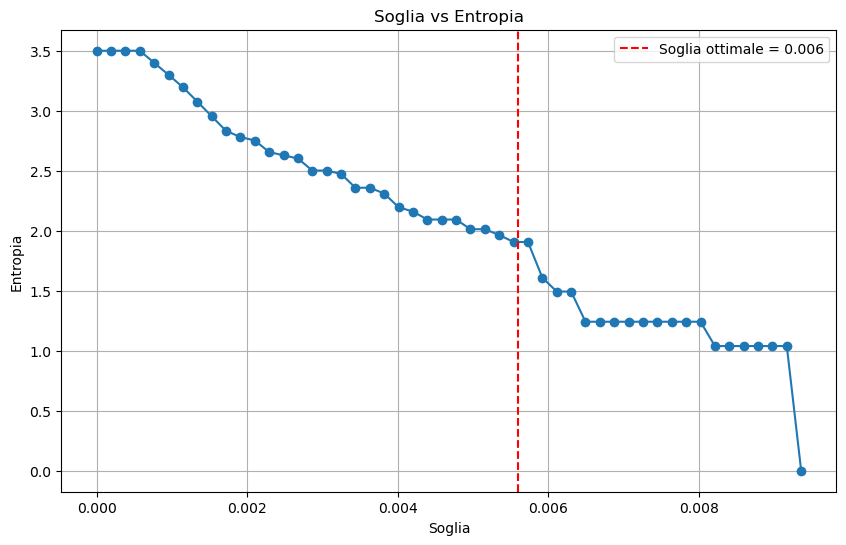

File salvati per Gephi:
Nodi: nodes_binary_for_gephi_cluster2.csv
Link: links_binary_for_gephi_cluster2.csv


In [28]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Funzione per calcolare l'entropia del grafo
def calculate_graph_entropy(graph):
    degrees = np.array([deg for _, deg in graph.degree()])
    if degrees.sum() == 0:  # Evitare divisioni per zero
        return 0
    probabilities = degrees / degrees.sum()
    return entropy(probabilities)

# Definire soglie e calcolare l'entropia per ciascuna soglia
thresholds = np.linspace(0, max(nx.get_edge_attributes(G, 'weight').values()), 50)  # 50 livelli di soglia
entropies = []

for threshold in thresholds:
    G_binary = nx.Graph()
    for u, v, data in G.edges(data=True):
        if data['weight'] > threshold:
            G_binary.add_edge(u, v)  # Aggiungere arco senza pesi
    # Calcolare l'entropia del grafo per la soglia corrente
    entropies.append(calculate_graph_entropy(G_binary))

# Trovare la soglia che massimizza l'entropia
max_entropy_index = np.argmax(entropies)
optimal_threshold =0.0056 #thresholds[max_entropy_index]
print(f"Soglia ottimale: {optimal_threshold}, Entropia massima: {entropies[max_entropy_index]}")

# Grafico Soglia vs Entropia
plt.figure(figsize=(10, 6))
plt.plot(thresholds, entropies, marker='o')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Soglia ottimale = {optimal_threshold:.3f}')
plt.xlabel('Soglia')
plt.ylabel('Entropia')
plt.title('Soglia vs Entropia')
plt.legend()
plt.grid()
plt.show()

# Binarizzare il grafo usando la soglia ottimale
G_binary = nx.Graph()
for u, v, data in G.edges(data=True):
    if data['weight'] > optimal_threshold:
        G_binary.add_edge(u, v)  # Aggiungere arco senza pesi

# Calcolare le metriche del grafo binarizzato
degree = dict(G_binary.degree())
betweenness = nx.betweenness_centrality(G_binary)
closeness = nx.closeness_centrality(G_binary)
eigenvector = nx.eigenvector_centrality(G_binary, max_iter=500)

# Creare il dataframe dei nodi per Gephi
nodes_binary_df = pd.DataFrame({
    'Id': list(G_binary.nodes()),
    'Degree': [degree[node] for node in G_binary.nodes()],
    'Betweenness': [betweenness[node] for node in G_binary.nodes()],
    'Closeness': [closeness[node] for node in G_binary.nodes()],
    'Eigenvector': [eigenvector[node] for node in G_binary.nodes()]
})
nodes_binary_df.to_csv("nodes_binary_for_gephi_cluster2.csv", index=False)

# Creare il dataframe dei link per Gephi
links_binary_df = pd.DataFrame(
    [(u, v) for u, v in G_binary.edges()],
    columns=["Source", "Target"]
)
links_binary_df.to_csv("links_binary_for_gephi_cluster2.csv", index=False)

print("File salvati per Gephi:")
print("Nodi: nodes_binary_for_gephi_cluster2.csv")
print("Link: links_binary_for_gephi_cluster2.csv")


Soglia ottimale: 0.0021, Entropia massima: 2.380615934011905


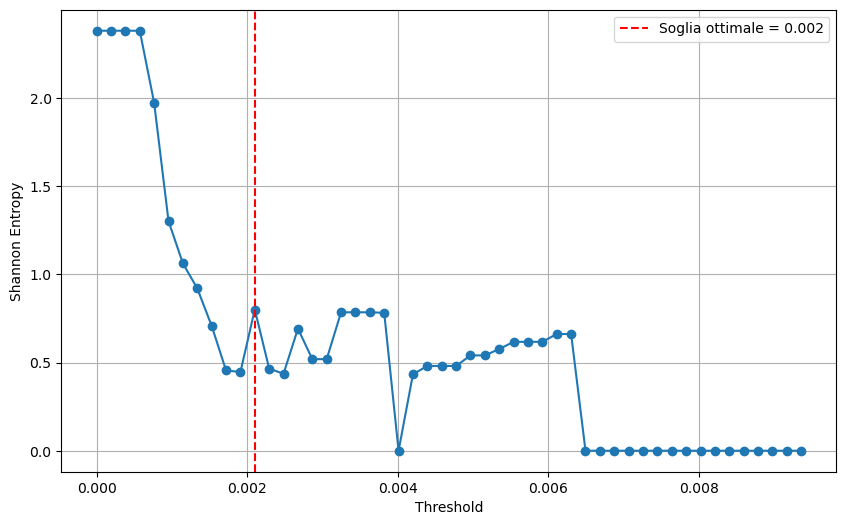

File salvati per Gephi:
Nodi: nodes_binary_for_gephi_cluster2.csv
Link: links_binary_for_gephi_cluster2.csv


In [31]:
import networkx as nx
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt

# Funzione per calcolare l'entropia della betweenness centrality
def calculate_betweenness_entropy(graph):
    betweenness = nx.betweenness_centrality(graph)  # Freeman's betweenness centrality
    values = np.array(list(betweenness.values()))  # Convert to array
    if values.sum() == 0:  # Handle empty graphs or zero betweenness
        return 0
    probabilities = values / values.sum()  # Normalize to probabilities
    return entropy(probabilities)  # Shannon entropy

# Definire soglie e calcolare l'entropia per ciascuna soglia
thresholds = np.linspace(0, max(nx.get_edge_attributes(G, 'weight').values()), 50)  # 50 livelli di soglia
entropies = []

for threshold in thresholds:
    G_binary = nx.Graph()
    for u, v, data in G.edges(data=True):
        if data['weight'] > threshold:
            G_binary.add_edge(u, v)  # Aggiungere arco senza peso
    # Calcolare l'entropia della betweenness centrality
    entropies.append(calculate_betweenness_entropy(G_binary))

# Trovare la soglia che massimizza l'entropia
max_entropy_index = np.argmax(entropies)
optimal_threshold = 0.0021#thresholds[max_entropy_index]
print(f"Soglia ottimale: {optimal_threshold}, Entropia massima: {entropies[max_entropy_index]}")

# Grafico Soglia vs Entropia
plt.figure(figsize=(10, 6))
plt.plot(thresholds, entropies, marker='o')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Soglia ottimale = {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Shannon Entropy')
plt.title('')
plt.legend()
plt.grid()
plt.show()

# Binarizzare il grafo usando la soglia ottimale
G_binary = nx.Graph()
for u, v, data in G.edges(data=True):
    if data['weight'] > optimal_threshold:
        G_binary.add_edge(u, v)  # Aggiungere arco senza peso

# Calcolare le metriche del grafo binarizzato
degree = dict(G_binary.degree())
betweenness = nx.betweenness_centrality(G_binary)
closeness = nx.closeness_centrality(G_binary)
eigenvector = nx.eigenvector_centrality(G_binary, max_iter=500)

# Creare il dataframe dei nodi per Gephi
nodes_binary_df = pd.DataFrame({
    'Id': list(G_binary.nodes()),
    'Degree': [degree[node] for node in G_binary.nodes()],
    'Betweenness': [betweenness[node] for node in G_binary.nodes()],
    'Closeness': [closeness[node] for node in G_binary.nodes()],
    'Eigenvector': [eigenvector[node] for node in G_binary.nodes()]
})
nodes_binary_df.to_csv("nodes_binary_for_gephi_cluster2.csv", index=False)

# Creare il dataframe dei link per Gephi
links_binary_df = pd.DataFrame(
    [(u, v) for u, v in G_binary.edges()],
    columns=["Source", "Target"]
)
links_binary_df.to_csv("links_binary_for_gephi_cluster2.csv", index=False)

print("File salvati per Gephi:")
print("Nodi: nodes_binary_for_gephi_cluster2.csv")
print("Link: links_binary_for_gephi_cluster2.csv")

# cluster 5

In [32]:

# Lista dei soggetti di interesse
subjects_of_interest = ['SRR2143742', 'SRR2144028', 'SRR2143686', 'SRR2143927', 'SRR2143974',
       'SRR2143946', 'SRR2143573', 'SRR2143563', 'ERR475590', 'SRR2143604',
       'SRR2143700', 'SRR2143981', 'SRR2143862', 'SRR2143882', 'SRR2143987',
       'SRR2143756', 'Adenoma3-2123', 'Adenoma9-2717', 'SRR2144072',
       'SRR2144097', 'SRR2143713', 'SRR2144007']

# Caricamento dati
df = pd.read_csv('df.csv', index_col=0)
metadata = pd.read_csv('metadata.csv').set_index('SampleID')

# Preprocessing dei dati
df['Gender_m'] = df['Gender_m'].astype(int)
df['Country_CA'] = df['Country_CA'].astype(int)
df['Country_FRA'] = df['Country_FRA'].astype(int)
df['Country_USA'] = df['Country_USA'].astype(int)
df = df.dropna()
metadata = metadata.loc[df.index]

X = df.iloc[:, :-1]  # Features
y = (metadata['Diagnosis'] == 'Cancer').astype(int)  # Target

# Impostazioni Cross-Validation
np.random.seed(42)
cv_repeats = 20
random_states = np.random.randint(10000, size=cv_repeats)


# Calcolo dei valori di interazione SHAP per i soggetti di interesse
shap_interaction_values_interest = pd.DataFrame(0, index=X.columns, columns=X.columns)
fold_count_interest = 0

# Filtrare X per i soggetti di interesse
X_interest = X.loc[subjects_of_interest]

# Impostazioni Cross-Validation
for repeat, random_state in enumerate(tqdm(random_states, desc="Repeats")):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(X, y), desc=f"Repeat {repeat + 1}", leave=False, total=5)):
        # Training e test split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Modello CatBoost
        model = CatBoostClassifier(random_state=42, verbose=0)
        model.fit(X_train, y_train)

        # Calcolo dei valori di interazione SHAP solo per i soggetti di interesse
        explainer = shap.TreeExplainer(model)
        shap_interaction_values = explainer.shap_interaction_values(X_interest)

        # Accumulare i valori di interazione
        shap_interaction_values_interest += np.abs(shap_interaction_values).mean(axis=0)
        fold_count_interest += 1

# Calcolo della media dei valori di interazione SHAP
shap_interaction_values_interest /= fold_count_interest

# Creare un nuovo file per salvare i risultati
new_save_path = "shap_interaction_results_cluster5"
os.makedirs(new_save_path, exist_ok=True)

# Funzione per salvare i risultati con un nome diverso
def save_shap_interactions_interest(shap_interaction_values_avg, columns, save_path):
    # Assicurarsi che shap_interaction_values_avg sia una matrice quadrata
    interaction_df = pd.DataFrame(
        shap_interaction_values_avg,
        index=columns,
        columns=columns
    )

    # Convertire i valori di interazione in un formato lungo
    interaction_long = []
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            interaction_long.append([
                columns[i], columns[j], interaction_df.iloc[i, j]
            ])
    
    interaction_long_df = pd.DataFrame(
        interaction_long, columns=['Feature1', 'Feature2', 'Interaction']
    )
    interaction_long_df = interaction_long_df.sort_values(by='Interaction', ascending=False)

    # Salvare i risultati
    interaction_long_df.to_csv(os.path.join(save_path, 'shap_interaction_values_cluster5_long.csv'), index=False)
    interaction_df.to_csv(os.path.join(save_path, 'shap_interaction_values_cluster5_matrix.csv'))

    return interaction_long_df

# Salvare i risultati
save_shap_interactions_interest(shap_interaction_values_interest, X.columns, new_save_path)

print("Valori di interazione SHAP per i soggetti di interesse salvati con successo.")


Repeats: 100%|███████████████████████████████| 20/20 [1:07:24<00:00, 202.22s/it]

Valori di interazione SHAP per i soggetti di interesse salvati con successo.


In [33]:
shap_long=pd.read_csv('shap_interaction_results_cluster5/shap_interaction_values_cluster5_long.csv')
shap_long

,Feature1,Feature2,Interaction
0,Fusobacterium,Akkermansia,0.006254
1,Sellimonas,Lachnospiraceae_UCG-010,0.005675
2,Fusobacterium,Eggerthella,0.005190
3,Fusobacterium,Romboutsia,0.005015
4,Fusobacterium,_Eubacterium__nodatum_group,0.004434
...,...,...,...
14360,Eggerthella,Country_FRA,0.000000
14361,Lachnospiraceae_NK4A136_group,Country_FRA,0.000000
14362,Lachnospiraceae_UCG-004,Country_FRA,0.000000
14363,Hungatella,Country_USA,0.000000


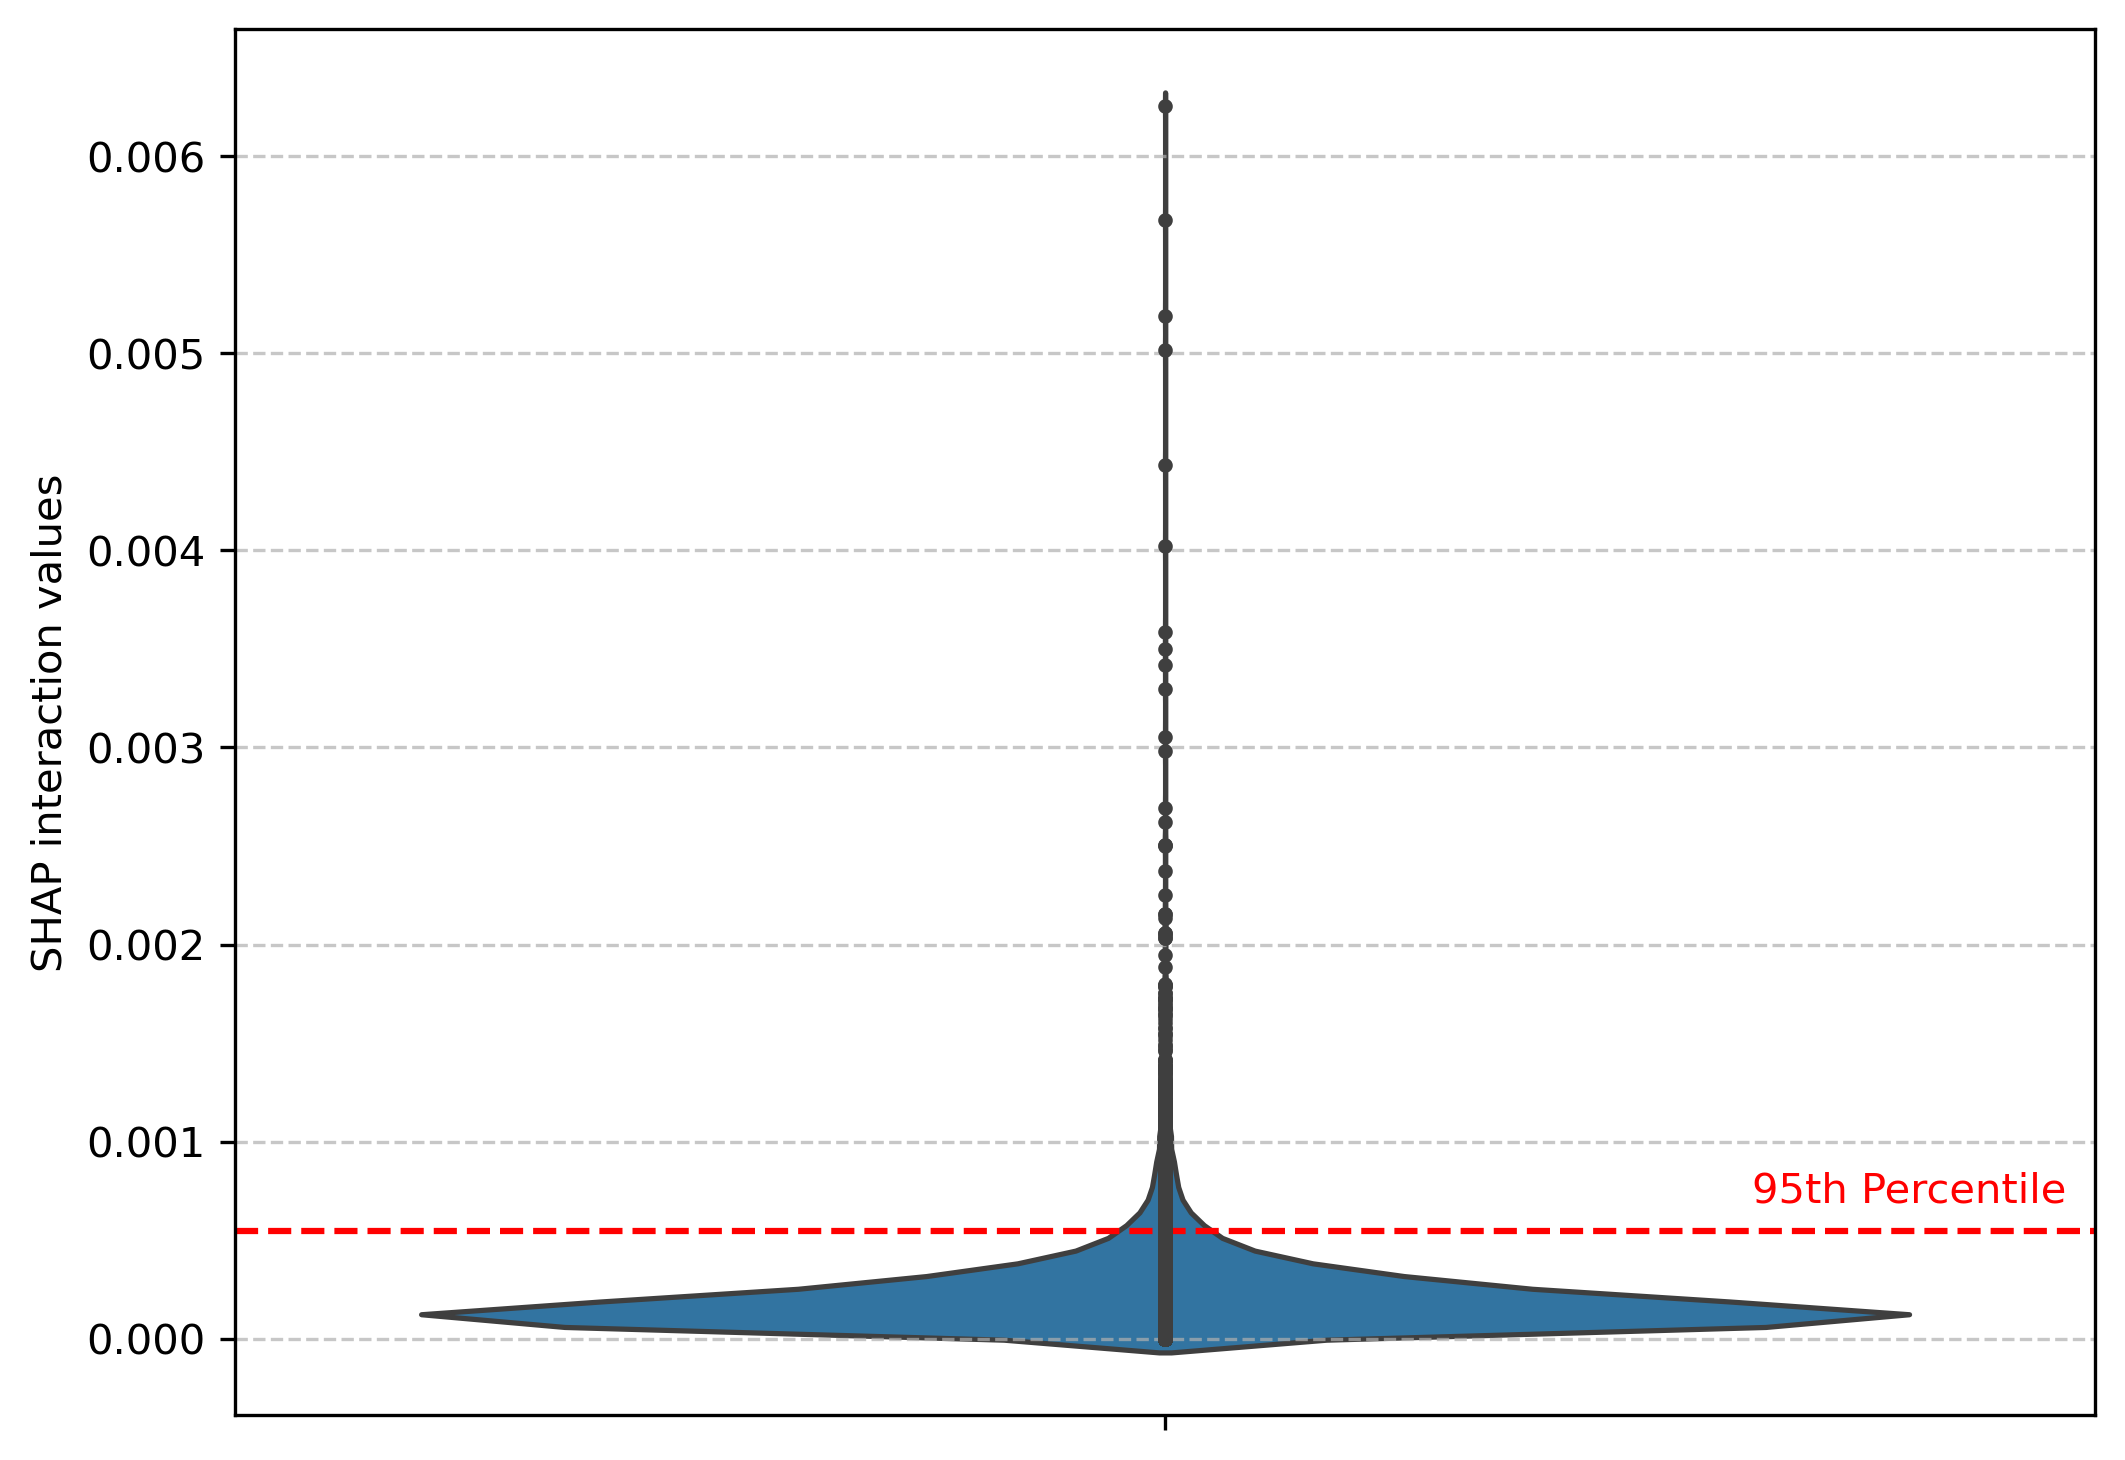

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creazione del violin plot
plt.figure(figsize=(8, 6), dpi=300)
sns.violinplot(y='Interaction', data=shap_long, inner='point')

# Aggiunta della linea al 95° percentile
percentile = shap_long['Interaction'].quantile(0.95)
plt.axhline(y=percentile, color='red', linestyle='--', label='95° Percentile')

# Aggiunta del testo sulla linea
plt.text(
    x=0.4, 
    y=percentile + 0.0001,  # Posizione leggermente sopra la linea
    s='95th Percentile', 
    color='red', 
    fontsize=10, 
    ha='center', 
    va='bottom'
)

plt.title('')
plt.xlabel('')
plt.ylabel('SHAP interaction values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


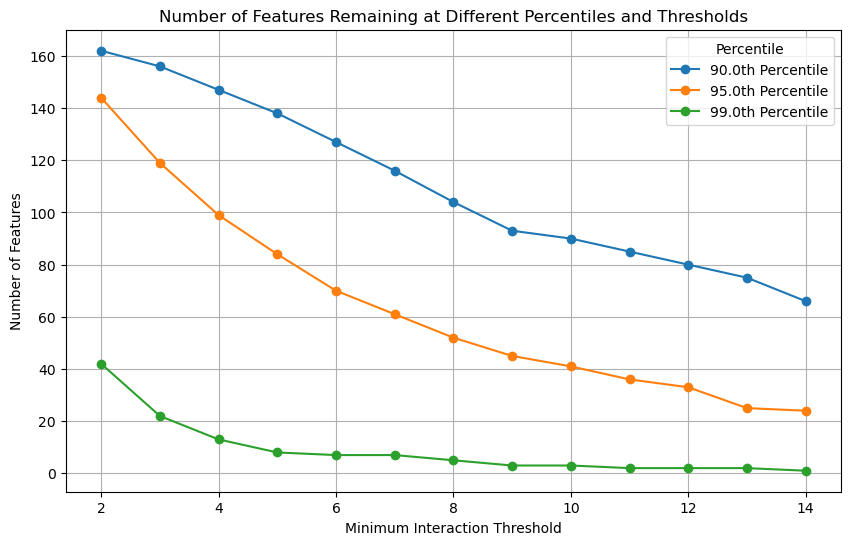

,Feature,Count
0,Fusobacterium,158
1,Parvimonas,59
2,Porphyromonas,57
3,BMI,53
4,Peptostreptococcus,53
5,Lachnospiraceae_UCG-010,49
6,Bilophila,38
7,Akkermansia,24
8,NK4A214_group,22
9,Marvinbryantia,22


In [35]:
# Initialize variables for thresholds and counts
percentiles = [0.90, 0.95, 0.99]
thresholds = range(2, 15)  # Minimum interaction count
result_matrix = []

# Iterate over percentiles and thresholds
for percentile in percentiles:
    threshold_value = shap_long["Interaction"].quantile(percentile)
    shap_filtered = shap_long[shap_long["Interaction"] >= threshold_value]

    interaction_counts = pd.concat([
        shap_filtered["Feature1"],
        shap_filtered["Feature2"]
    ]).value_counts()

    for threshold in thresholds:
        filtered_count = interaction_counts[interaction_counts >= threshold].shape[0]
        result_matrix.append({"Percentile": percentile, "Threshold": threshold, "Count": filtered_count})

# Convert results to a DataFrame
result_df = pd.DataFrame(result_matrix)

# Plot the results
plt.figure(figsize=(10, 6))
for percentile in percentiles:
    subset = result_df[result_df["Percentile"] == percentile]
    plt.plot(subset["Threshold"], subset["Count"], marker="o", label=f"{percentile*100}th Percentile")

plt.xlabel("Minimum Interaction Threshold")
plt.ylabel("Number of Features")
plt.title("Number of Features Remaining at Different Percentiles and Thresholds")
plt.legend(title="Percentile")
plt.grid(True)
plt.show()

# Filtered Interaction Counts for the final configuration
final_percentile = 0.95
final_threshold = 10

threshold_value_final = shap_long["Interaction"].quantile(final_percentile)
shap_filtered_final = shap_long[shap_long["Interaction"] >= threshold_value_final]

interaction_counts_final = pd.concat([
    shap_filtered_final["Feature1"],
    shap_filtered_final["Feature2"]
]).value_counts()

filtered_interaction_counts_final = interaction_counts_final[interaction_counts_final >= final_threshold]

# Display the final filtered interaction counts
filtered_interaction_counts_final.reset_index(name='Count').rename(columns={'index': 'Feature'})

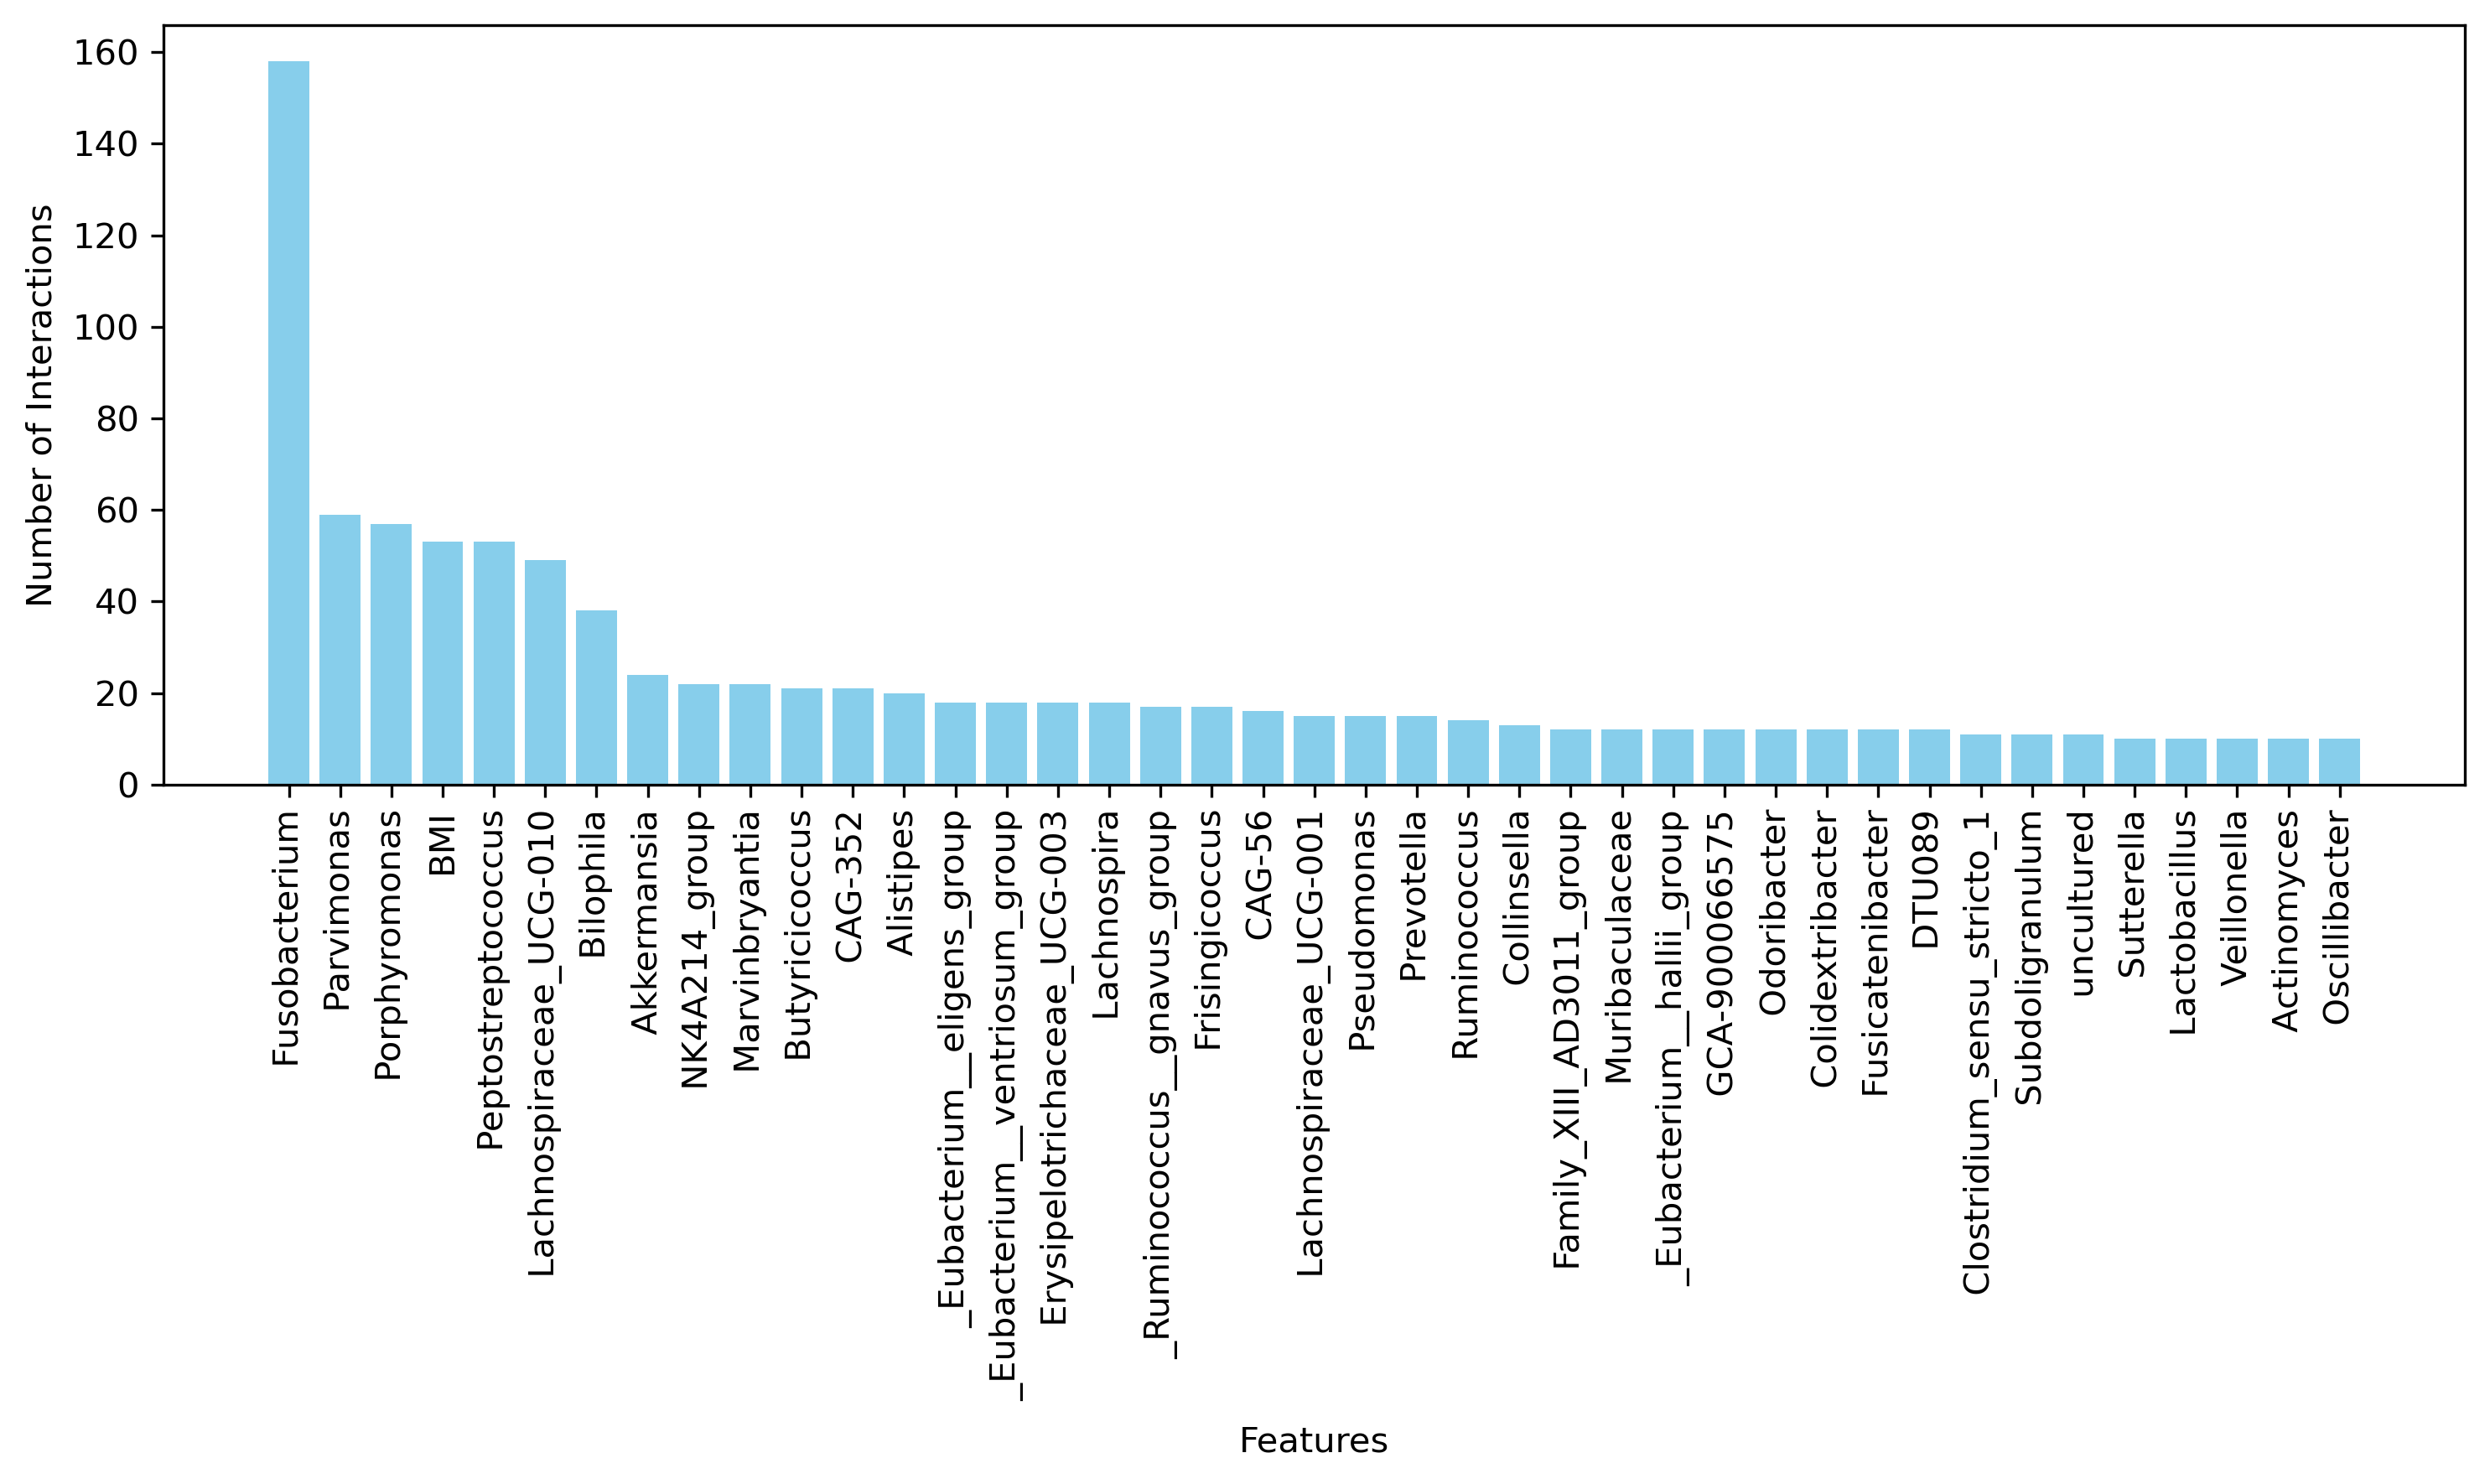

In [36]:
# Prepare the filtered interaction counts DataFrame
filtered_interaction_counts_df = (
    filtered_interaction_counts_final
    .reset_index(name='Count')
    .rename(columns={'index': 'Feature'})
)

# Plot the histogram of the 'Count' column
plt.figure(figsize=(10, 6),dpi=300)
plt.bar(
    filtered_interaction_counts_df['Feature'], 
    filtered_interaction_counts_df['Count'], 
    color='skyblue'
)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Number of Interactions")
plt.title("")
plt.tight_layout()
plt.show()

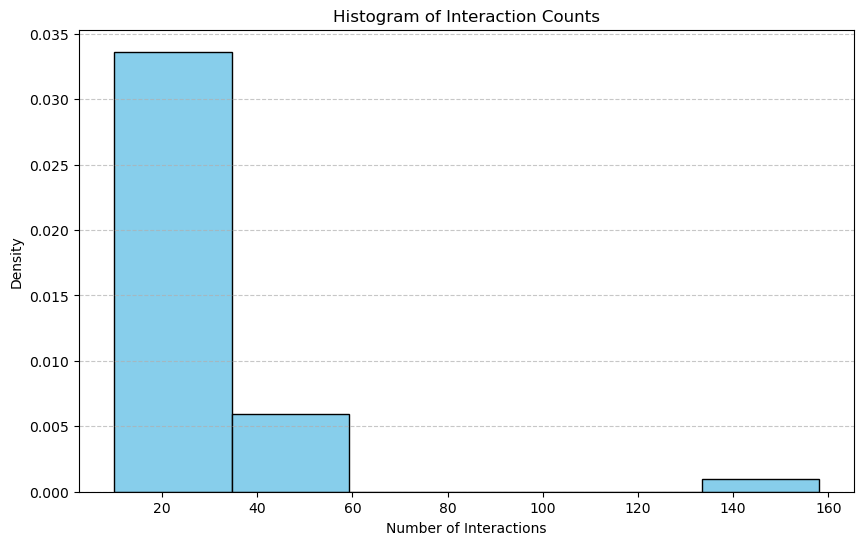

In [37]:
# Plotting the histogram of the 'Count' column
plt.figure(figsize=(10, 6))
plt.hist(filtered_interaction_counts_df['Count'], bins=6, color='skyblue', density =True,edgecolor='black')
plt.xlabel("Number of Interactions")
plt.ylabel("Density")
plt.title("Histogram of Interaction Counts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [38]:
# Selezione del 95° percentile del dataframe basandosi sulla colonna 'Interaction'
threshold_95 = shap_long['Interaction'].quantile(0.95)
shap_long_95_percentile = shap_long[shap_long['Interaction'] >= threshold_95]
shap_long_95_percentile

,Feature1,Feature2,Interaction
0,Fusobacterium,Akkermansia,0.006254
1,Sellimonas,Lachnospiraceae_UCG-010,0.005675
2,Fusobacterium,Eggerthella,0.005190
3,Fusobacterium,Romboutsia,0.005015
4,Fusobacterium,_Eubacterium__nodatum_group,0.004434
...,...,...,...
714,Porphyromonas,Fusicatenibacter,0.000549
715,Bifidobacterium,Turicibacter,0.000549
716,UCG-002,Eisenbergiella,0.000549
717,Muribaculaceae,_Eubacterium__xylanophilum_group,0.000548


In [39]:
# Calcolare il numero di interazioni sopra il 95° percentile per ciascuna feature
# Combinare le colonne Feature1 e Feature2 in un unico array, poi contare le occorrenze
interaction_counts = pd.concat([
    shap_long_95_percentile['Feature1'], 
    shap_long_95_percentile['Feature2']
]).value_counts()

# Convertire in un DataFrame per una rappresentazione più leggibile
interaction_counts_df = interaction_counts.reset_index()
interaction_counts_df.columns = ['Feature', 'Count']

# Ordinare il DataFrame in base al numero di interazioni
interaction_counts_df = interaction_counts_df.sort_values(by='Count', ascending=False)

# Mostrare i risultati
print(interaction_counts_df)

                          Feature  Count
0                   Fusobacterium    158
1                      Parvimonas     59
2                   Porphyromonas     57
3                             BMI     53
4              Peptostreptococcus     53
..                            ...    ...
148                 GCA-900066755      1
146       Lachnospiraceae_UCG-004      1
145           Family_XIII_UCG-001      1
144   Lachnospiraceae_NK4B4_group      1
162                      Moryella      1

[163 rows x 2 columns]


In [40]:
# Definire una soglia minima di interazioni
interaction_threshold = 10

# Filtrare il DataFrame per mantenere solo le righe che superano la soglia
filtered_interaction_counts_df = interaction_counts_df[interaction_counts_df['Count'] >= interaction_threshold]

# Mostrare il sotto-DataFrame
print(filtered_interaction_counts_df)

                            Feature  Count
0                     Fusobacterium    158
1                        Parvimonas     59
2                     Porphyromonas     57
3                               BMI     53
4                Peptostreptococcus     53
5           Lachnospiraceae_UCG-010     49
6                         Bilophila     38
7                       Akkermansia     24
9                    Marvinbryantia     22
8                     NK4A214_group     22
10                   Butyricicoccus     21
11                          CAG-352     21
12                        Alistipes     20
13      _Eubacterium__eligens_group     18
14   _Eubacterium__ventriosum_group     18
15      Erysipelotrichaceae_UCG-003     18
16                      Lachnospira     18
17      _Ruminococcus__gnavus_group     17
18                   Frisingicoccus     17
19                           CAG-56     16
20          Lachnospiraceae_UCG-001     15
21                      Pseudomonas     15
22         

In [41]:
# Definire una soglia minima di interazioni
interaction_threshold = 10

# Filtrare le feature che superano la soglia
features_above_threshold = interaction_counts_df[interaction_counts_df['Count'] >= interaction_threshold]['Feature']

# Creare un sotto-dataframe che contiene solo le interazioni tra queste feature
filtered_shap_long = shap_long_95_percentile[
    (shap_long_95_percentile['Feature1'].isin(features_above_threshold)) &
    (shap_long_95_percentile['Feature2'].isin(features_above_threshold))
].reset_index(drop=True)

# Mostrare il sotto-dataframe
filtered_shap_long

,Feature1,Feature2,Interaction
0,Fusobacterium,Akkermansia,0.006254
1,Fusobacterium,Frisingicoccus,0.003502
2,Porphyromonas,Lachnospiraceae_UCG-010,0.003421
3,Fusobacterium,Prevotella,0.003298
4,Muribaculaceae,Lachnospiraceae_UCG-001,0.002983
...,...,...,...
275,Sutterella,BMI,0.000551
276,Prevotella,_Eubacterium__eligens_group,0.000550
277,Lactobacillus,Frisingicoccus,0.000549
278,Porphyromonas,Fusicatenibacter,0.000549


In [42]:
import networkx as nx
# Ensure 'Count' is numeric
filtered_interaction_counts_df['Count'] = pd.to_numeric(filtered_interaction_counts_df['Count'], errors='coerce')

# Check if there are any NaN values
if filtered_interaction_counts_df['Count'].isna().any():
    print("Found NaN values in 'Count'. Dropping these rows.")
    filtered_interaction_counts_df = filtered_interaction_counts_df.dropna(subset=['Count'])

# Convert 'Count' to integer type
filtered_interaction_counts_df['Count'] = filtered_interaction_counts_df['Count'].astype(int)

# Define size classes and assign sizes
size_classes = [100, 250, 500, 1000]  # Adjust node size ranges for visualization
filtered_interaction_counts_df['Size'] = pd.cut(
    filtered_interaction_counts_df['Count'].values, 
    bins=4, 
    labels=size_classes
)

# Build the graph
G = nx.Graph()

# Add nodes with size (proportional to 'Count')
for _, row in filtered_interaction_counts_df.iterrows():
    G.add_node(row['Feature'], size=int(row['Size']))

# Add edges with weights
for _, row in filtered_shap_long.iterrows():
    G.add_edge(row['Feature1'], row['Feature2'], weight=row['Interaction'])

/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_17743/3791231091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interaction_counts_df['Count'] = pd.to_numeric(filtered_interaction_counts_df['Count'], errors='coerce')
/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_17743/3791231091.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interaction_counts_df['Count'] = filtered_interaction_counts_df['Count'].astype(int)
/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/

In [43]:
# Print edges with weights
print("Edges with weights:")
for u, v, data in G.edges(data=True):
    print(f"{u} -- {v}, weight: {data['weight']}")

Edges with weights:
 Fusobacterium --  Akkermansia, weight: 0.006254288821807
 Fusobacterium --  Frisingicoccus, weight: 0.0035020512614132
 Fusobacterium --  Prevotella, weight: 0.003298209304618
 Fusobacterium --  Erysipelotrichaceae_UCG-003, weight: 0.0026238826361703
 Fusobacterium --  CAG-56, weight: 0.0025036436605727
 Fusobacterium --  Butyricicoccus, weight: 0.0025002322661894
 Fusobacterium -- BMI, weight: 0.0020574587442774
 Fusobacterium --  Porphyromonas, weight: 0.0019454514285746
 Fusobacterium --  Fusicatenibacter, weight: 0.0018012433680806
 Fusobacterium --  Subdoligranulum, weight: 0.0017926068722302
 Fusobacterium --  Oscillibacter, weight: 0.0017871955929904
 Fusobacterium --  uncultured, weight: 0.0017540046487522
 Fusobacterium --  Parvimonas, weight: 0.0017239381060568
 Fusobacterium --  Peptostreptococcus, weight: 0.0017228178694341
 Fusobacterium --  Veillonella, weight: 0.0017183105572926
 Fusobacterium --  Bilophila, weight: 0.0017033321878653
 Fusobacterium 

In [44]:
# Save the edges dataframe with source, target, and weight
edges_df = filtered_shap_long[['Feature1', 'Feature2', 'Interaction']].rename(
    columns={'Feature1': 'Source', 'Feature2': 'Target', 'Interaction': 'Weight'}
)
edges_df.to_csv("edges_cluster5.csv", index=False)

In [45]:
# Calcolare varie metriche per la rete pesata
degree = dict(G.degree(weight='weight'))
betweenness = nx.betweenness_centrality(G, weight='weight')
closeness = nx.closeness_centrality(G, distance='weight')
eigenvector = nx.eigenvector_centrality(G, weight='weight', max_iter=500)
pagerank = nx.pagerank(G, weight='weight')

# Creare un dataframe per analizzare i risultati
import pandas as pd
metrics_df = pd.DataFrame({
    'Degree': degree,
    'Betweenness': betweenness,
    'Closeness': closeness,
    'Eigenvector': eigenvector,
    'PageRank': pagerank
})

# Ordinare i nodi in base alla metrica desiderata (es. PageRank)
metrics_df = metrics_df.sort_values(by='Eigenvector', ascending=False)
print(metrics_df.head(10))  # Top 10 nodi

                            Degree  Betweenness    Closeness  Eigenvector  \
 Fusobacterium            0.069384     0.001282   726.152566     0.506138   
BMI                       0.031975     0.130769  1097.026728     0.266478   
 Lachnospiraceae_UCG-010  0.027981     0.025641   939.658597     0.258756   
 Akkermansia              0.016852     0.024359   944.954166     0.246513   
 Porphyromonas            0.023836     0.076923  1069.304803     0.225856   
 Peptostreptococcus       0.025263     0.083333  1108.339612     0.211485   
 Bilophila                0.021602     0.032051   948.457852     0.200913   
 Parvimonas               0.021261     0.039744   995.912964     0.187625   
 Prevotella               0.011039     0.017949   875.906048     0.149629   
 Alistipes                0.013295     0.035897   943.491994     0.148752   

                          PageRank  
 Fusobacterium            0.118471  
BMI                       0.055903  
 Lachnospiraceae_UCG-010  0.048332  
 Akk

In [46]:
# Map the number of interactions to each node from 'filtered_interaction_counts_df'
interaction_counts_dict = dict(filtered_interaction_counts_df.set_index('Feature')['Count'])

# Add the number of interactions to the metrics DataFrame
metrics_df['Interactions'] = metrics_df.index.map(interaction_counts_dict)

# Replace NaN with 0 for nodes that might not have interaction counts
metrics_df['Interactions'] = metrics_df['Interactions'].fillna(0).astype(int)

# Sort the dataframe by a selected metric (e.g., Eigenvector centrality)
metrics_df = metrics_df.sort_values(by='Interactions', ascending=False)

# Display the top 10 nodes
print(metrics_df.head(10))

                            Degree  Betweenness    Closeness  Eigenvector  \
 Fusobacterium            0.069384     0.001282   726.152566     0.506138   
 Parvimonas               0.021261     0.039744   995.912964     0.187625   
 Porphyromonas            0.023836     0.076923  1069.304803     0.225856   
 Peptostreptococcus       0.025263     0.083333  1108.339612     0.211485   
BMI                       0.031975     0.130769  1097.026728     0.266478   
 Lachnospiraceae_UCG-010  0.027981     0.025641   939.658597     0.258756   
 Bilophila                0.021602     0.032051   948.457852     0.200913   
 Akkermansia              0.016852     0.024359   944.954166     0.246513   
 NK4A214_group            0.010586     0.016667   824.225012     0.099929   
 Marvinbryantia           0.011689     0.035897   940.107448     0.115826   

                          PageRank  Interactions  
 Fusobacterium            0.118471           158  
 Parvimonas               0.038126            59  

In [47]:
metrics_df.to_csv('metrics_df_cluster5.csv')

In [49]:
import igraph as ig


# Convert the NetworkX graph to an igraph object
igraph_graph = ig.Graph.from_networkx(G)

# Ensure that the node names in igraph correspond to the node IDs in the NetworkX graph
igraph_graph.vs["name"] = list(G.nodes())

# Perform Leiden community detection for 500 iterations with varying seeds
partitions = {}
for s in range(500):
    np.random.seed(s)
    my_part = igraph_graph.community_leiden(
        objective_function="modularity",
        weights=igraph_graph.es["weight"],
        resolution_parameter=1.0,
        beta=0.01
    )
    partitions[s] = my_part.membership

# Find the most common partition
unique_partitions, counts = np.unique([partitions[i] for i in range(500)], return_counts=True, axis=0)
most_common_partition_index = np.argmax(counts)
most_common_partition = unique_partitions[most_common_partition_index]

# Align the partition to the correct order of nodes in metrics_df
igraph_node_order = list(igraph_graph.vs["name"])  # Names of nodes in igraph
aligned_partition = [most_common_partition[igraph_node_order.index(node)] for node in metrics_df.index]

# Add the aligned partition as the 'Community' column in metrics_df
metrics_df["Community"] = aligned_partition

# Save the nodes dataframe for Gephi
nodes_gephi = metrics_df.copy()
nodes_gephi.reset_index(inplace=True)
nodes_gephi.rename(columns={"index": "Id"}, inplace=True)  # Rename the index column to 'Id' for Gephi
nodes_gephi.to_csv("nodes_for_gephi_cluster5.csv", index=False)

# Calculate the modularity of the most common partition
modularity = igraph_graph.modularity(most_common_partition, weights=igraph_graph.es["weight"])
print(f"Modularity of the most common partition: {modularity}")


# Save the communities and modularity metrics
id_communities, card_communities = np.unique(most_common_partition, return_counts=True)
communities_summary = {
    "Community ID": id_communities,
    "Size": card_communities,
}
communities_summary_df = pd.DataFrame(communities_summary)
communities_summary_df.to_csv("communities_summary_cluster5.csv", index=False)

# Outputs
print("Nodes for Gephi saved to 'nodes_for_gephi_cluster5.csv'.")
print("Communities summary saved to 'communities_summary_cluster5.csv'.")
print(f"Modularity: {modularity}")

Modularity of the most common partition: 0.15192183350037147
Nodes for Gephi saved to 'nodes_for_gephi_cluster5.csv'.
Communities summary saved to 'communities_summary_cluster5.csv'.
Modularity: 0.15192183350037147


/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_17743/4227529879.py:14: DeprecationWarning: resolution_parameter keyword argument is deprecated, use resolution=... instead
  my_part = igraph_graph.community_leiden(


# cluster 6

In [50]:



# Lista dei soggetti di interesse
subjects_of_interest = ['SRR2143615', 'SRR2143802', 'SRR2143790', 'SRR2143620', 'SRR2143757',
       'SRR2143632', 'SRR2143804', 'SRR2143585', 'SRR2143610', 'SRR2143829',
       'SRR2143865', 'SRR2143831', 'SRR2143943', 'SRR2144122', 'ERR475489',
       'SRR2143833', 'SRR2143782', 'Adenoma20-2995', 'SRR2143568',
       'SRR2143608', 'Adenoma2-2113', 'SRR2143616', 'SRR2143726', 'SRR2144130',
       'SRR2143540', 'SRR2143753', 'SRR2143771', 'SRR2144111', 'SRR2143794',
       'SRR2143815', 'SRR2143671', 'SRR2143781', 'SRR2143701', 'SRR2143679',
       'SRR2143740', 'SRR2143959', 'ERR475490', 'SRR2143825', 'SRR2143878',
       'ERR475544', 'SRR2143623', 'SRR2144023', 'SRR2143939', 'SRR2143612',
       'SRR2143928', 'SRR2143528', 'SRR2143894', 'SRR2143944', 'SRR2143730',
       'SRR2143720', 'SRR2143938', 'SRR2143859', 'SRR2143731', 'ERR475496',
       'SRR2143673', 'SRR2143519', 'SRR2144016', 'SRR2143850', 'SRR2143738',
       'SRR2143952']

# Caricamento dati
df = pd.read_csv('df.csv', index_col=0)
metadata = pd.read_csv('metadata.csv').set_index('SampleID')

# Preprocessing dei dati
df['Gender_m'] = df['Gender_m'].astype(int)
df['Country_CA'] = df['Country_CA'].astype(int)
df['Country_FRA'] = df['Country_FRA'].astype(int)
df['Country_USA'] = df['Country_USA'].astype(int)
df = df.dropna()
metadata = metadata.loc[df.index]

X = df.iloc[:, :-1]  # Features
y = (metadata['Diagnosis'] == 'Cancer').astype(int)  # Target

# Impostazioni Cross-Validation
np.random.seed(42)
cv_repeats = 20
random_states = np.random.randint(10000, size=cv_repeats)


# Calcolo dei valori di interazione SHAP per i soggetti di interesse
shap_interaction_values_interest = pd.DataFrame(0, index=X.columns, columns=X.columns)
fold_count_interest = 0

# Filtrare X per i soggetti di interesse
X_interest = X.loc[subjects_of_interest]

# Impostazioni Cross-Validation
for repeat, random_state in enumerate(tqdm(random_states, desc="Repeats")):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    for fold, (train_idx, test_idx) in enumerate(tqdm(cv.split(X, y), desc=f"Repeat {repeat + 1}", leave=False, total=5)):
        # Training e test split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Modello CatBoost
        model = CatBoostClassifier(random_state=42, verbose=0)
        model.fit(X_train, y_train)

        # Calcolo dei valori di interazione SHAP solo per i soggetti di interesse
        explainer = shap.TreeExplainer(model)
        shap_interaction_values = explainer.shap_interaction_values(X_interest)

        # Accumulare i valori di interazione
        shap_interaction_values_interest += np.abs(shap_interaction_values).mean(axis=0)
        fold_count_interest += 1

# Calcolo della media dei valori di interazione SHAP
shap_interaction_values_interest /= fold_count_interest

# Creare un nuovo file per salvare i risultati
new_save_path = "shap_interaction_results_cluster6"
os.makedirs(new_save_path, exist_ok=True)

# Funzione per salvare i risultati con un nome diverso
def save_shap_interactions_interest(shap_interaction_values_avg, columns, save_path):
    # Assicurarsi che shap_interaction_values_avg sia una matrice quadrata
    interaction_df = pd.DataFrame(
        shap_interaction_values_avg,
        index=columns,
        columns=columns
    )

    # Convertire i valori di interazione in un formato lungo
    interaction_long = []
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            interaction_long.append([
                columns[i], columns[j], interaction_df.iloc[i, j]
            ])
    
    interaction_long_df = pd.DataFrame(
        interaction_long, columns=['Feature1', 'Feature2', 'Interaction']
    )
    interaction_long_df = interaction_long_df.sort_values(by='Interaction', ascending=False)

    # Salvare i risultati
    interaction_long_df.to_csv(os.path.join(save_path, 'shap_interaction_values_cluster6_long.csv'), index=False)
    interaction_df.to_csv(os.path.join(save_path, 'shap_interaction_values_cluster6_matrix.csv'))

    return interaction_long_df

# Salvare i risultati
save_shap_interactions_interest(shap_interaction_values_interest, X.columns, new_save_path)

print("Valori di interazione SHAP per i soggetti di interesse salvati con successo.")


Repeats: 100%|█████████████████████████████| 20/20 [19:59:31<00:00, 3598.58s/it]

Valori di interazione SHAP per i soggetti di interesse salvati con successo.


In [51]:
shap_long=pd.read_csv('shap_interaction_results_cluster6/shap_interaction_values_cluster6_long.csv')
shap_long

,Feature1,Feature2,Interaction
0,Sellimonas,Lachnospiraceae_UCG-010,0.004876
1,Muribaculaceae,Lachnospiraceae_UCG-001,0.002535
2,Alistipes,BMI,0.002265
3,Fusobacterium,Romboutsia,0.002265
4,Porphyromonas,Lachnospiraceae_UCG-010,0.002088
...,...,...,...
14360,_Eubacterium__xylanophilum_group,Country_FRA,0.000000
14361,Staphylococcus,Country_FRA,0.000000
14362,Lachnospiraceae_UCG-004,Country_FRA,0.000000
14363,Streptococcus,Country_FRA,0.000000


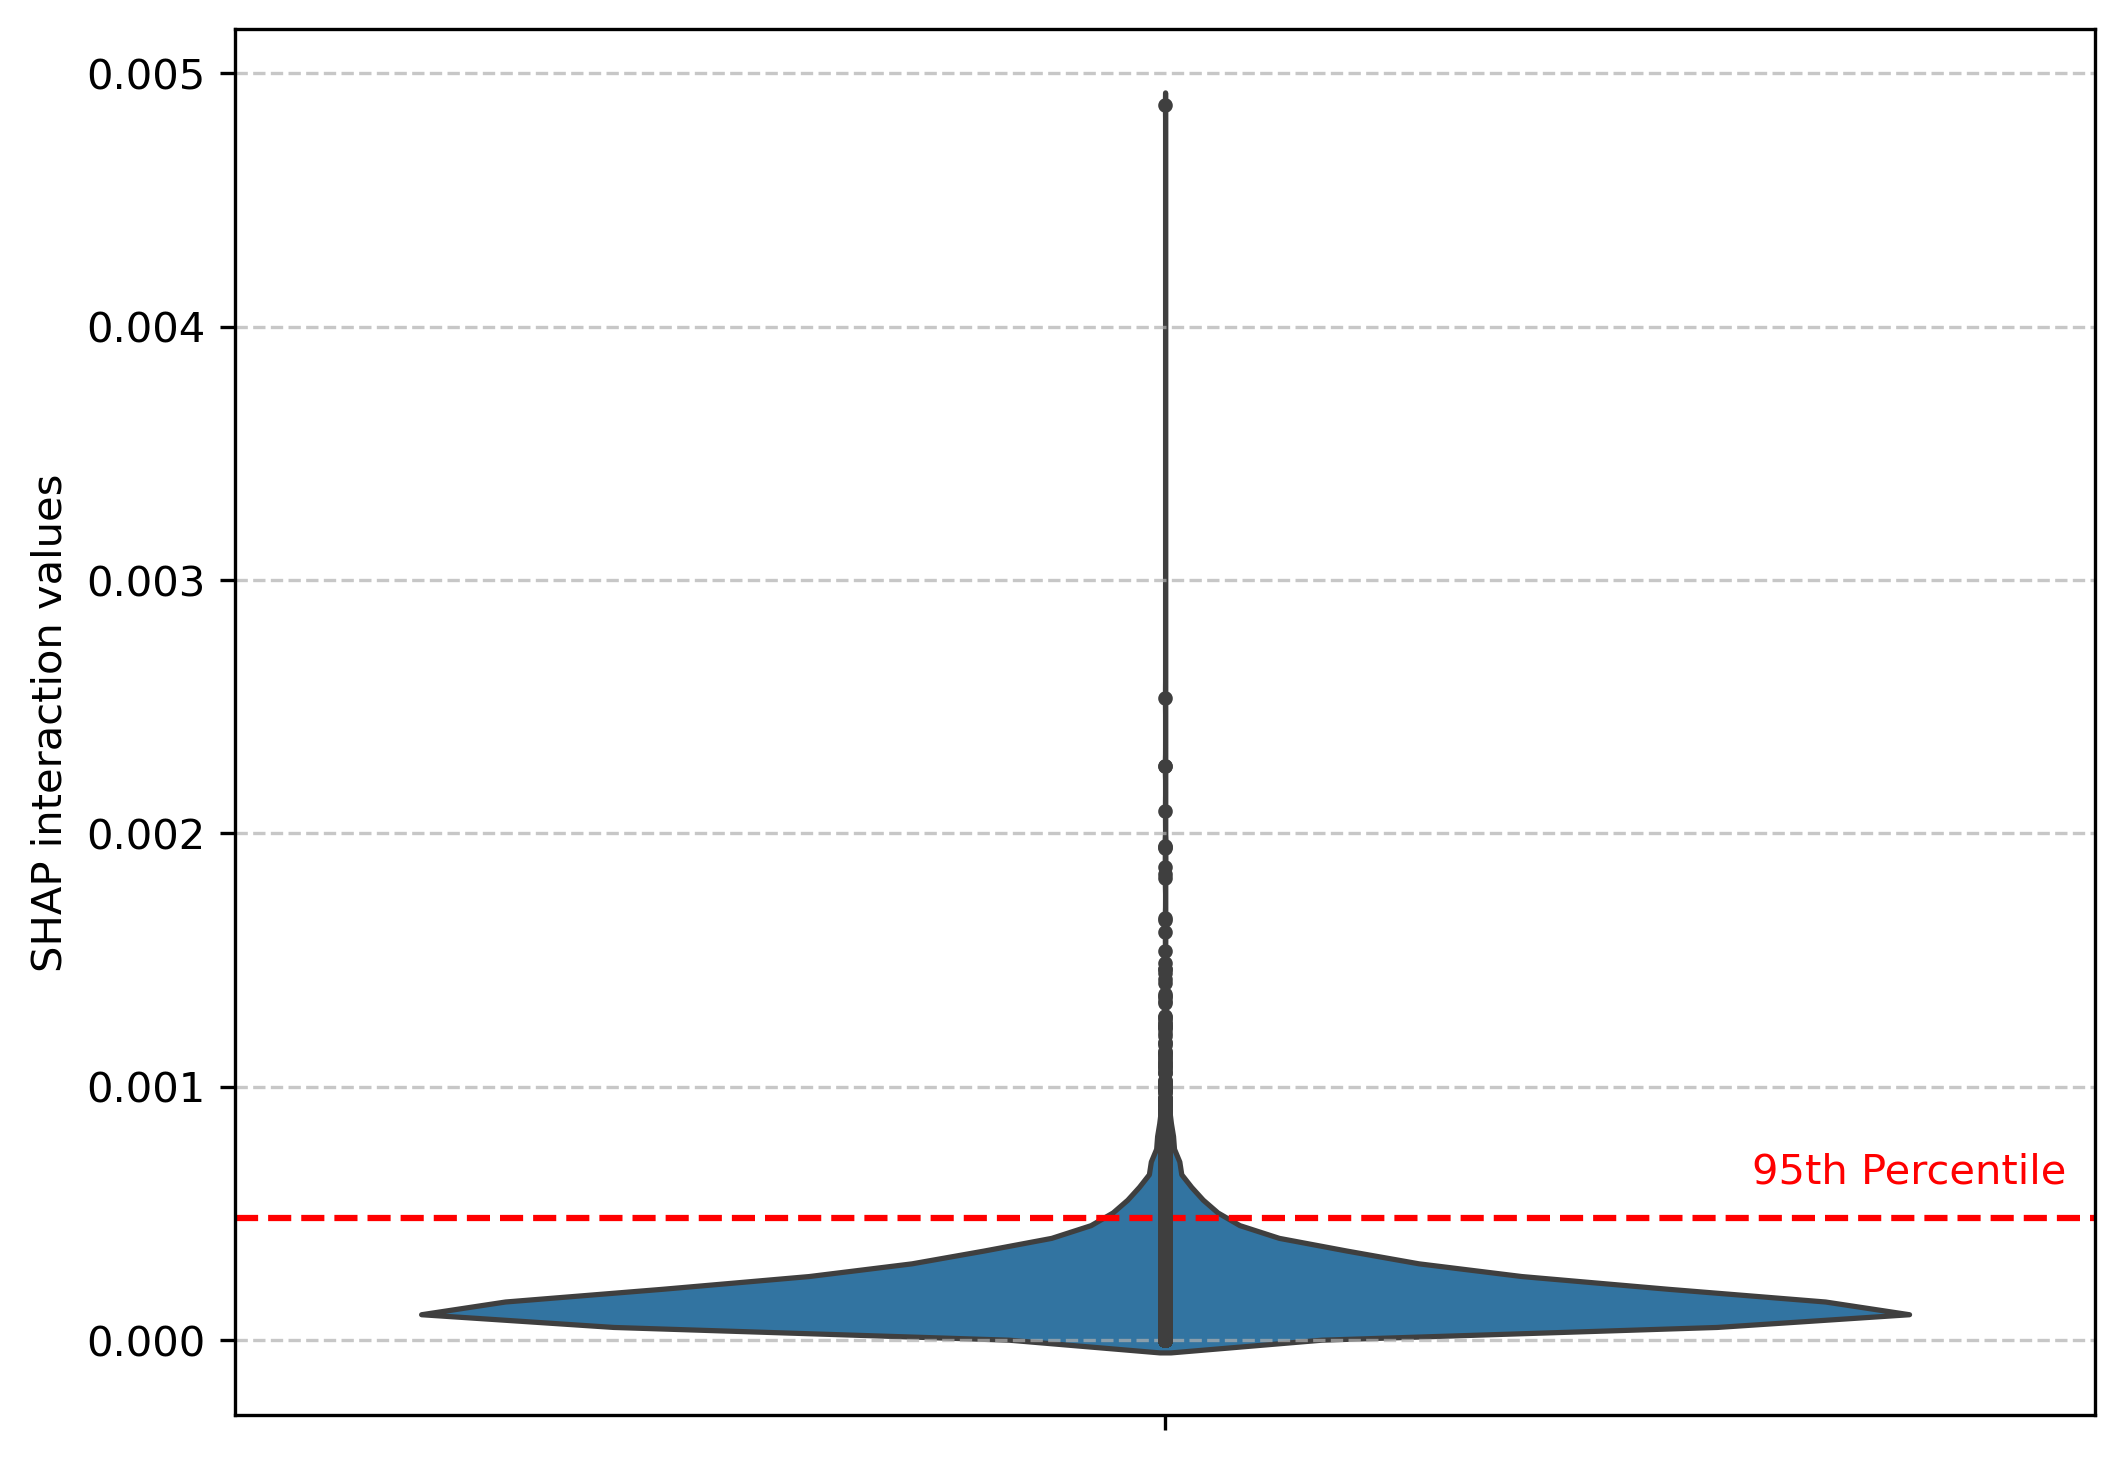

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Creazione del violin plot
plt.figure(figsize=(8, 6), dpi=300)
sns.violinplot(y='Interaction', data=shap_long, inner='point')

# Aggiunta della linea al 95° percentile
percentile = shap_long['Interaction'].quantile(0.95)
plt.axhline(y=percentile, color='red', linestyle='--', label='95° Percentile')

# Aggiunta del testo sulla linea
plt.text(
    x=0.4, 
    y=percentile + 0.0001,  # Posizione leggermente sopra la linea
    s='95th Percentile', 
    color='red', 
    fontsize=10, 
    ha='center', 
    va='bottom'
)

plt.title('')
plt.xlabel('')
plt.ylabel('SHAP interaction values')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

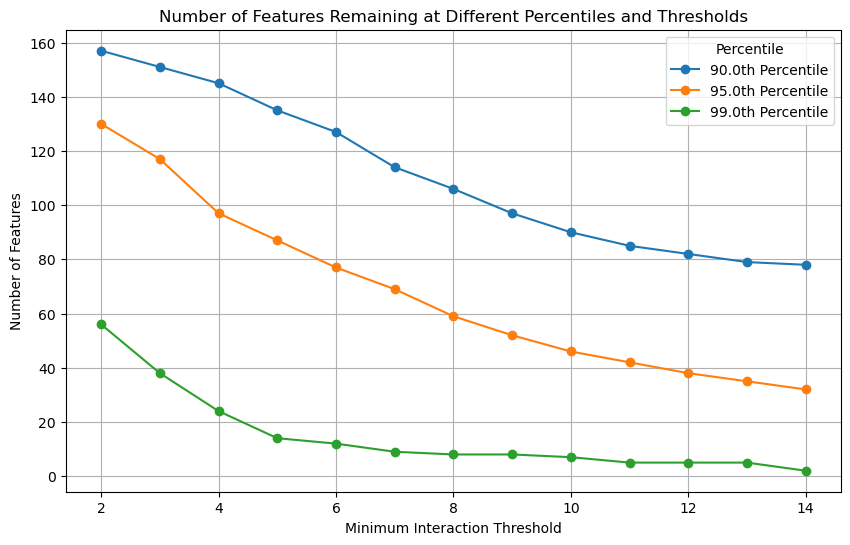

,Feature,Count
0,Parvimonas,70
1,Peptostreptococcus,58
2,BMI,52
3,Lachnospiraceae_UCG-010,48
4,Porphyromonas,45
5,Fusobacterium,44
6,Akkermansia,37
7,Marvinbryantia,32
8,CAG-56,28
9,NK4A214_group,27


In [53]:
# Initialize variables for thresholds and counts
percentiles = [0.90, 0.95, 0.99]
thresholds = range(2, 15)  # Minimum interaction count
result_matrix = []

# Iterate over percentiles and thresholds
for percentile in percentiles:
    threshold_value = shap_long["Interaction"].quantile(percentile)
    shap_filtered = shap_long[shap_long["Interaction"] >= threshold_value]

    interaction_counts = pd.concat([
        shap_filtered["Feature1"],
        shap_filtered["Feature2"]
    ]).value_counts()

    for threshold in thresholds:
        filtered_count = interaction_counts[interaction_counts >= threshold].shape[0]
        result_matrix.append({"Percentile": percentile, "Threshold": threshold, "Count": filtered_count})

# Convert results to a DataFrame
result_df = pd.DataFrame(result_matrix)

# Plot the results
plt.figure(figsize=(10, 6))
for percentile in percentiles:
    subset = result_df[result_df["Percentile"] == percentile]
    plt.plot(subset["Threshold"], subset["Count"], marker="o", label=f"{percentile*100}th Percentile")

plt.xlabel("Minimum Interaction Threshold")
plt.ylabel("Number of Features")
plt.title("Number of Features Remaining at Different Percentiles and Thresholds")
plt.legend(title="Percentile")
plt.grid(True)
plt.show()

# Filtered Interaction Counts for the final configuration
final_percentile = 0.95
final_threshold = 10

threshold_value_final = shap_long["Interaction"].quantile(final_percentile)
shap_filtered_final = shap_long[shap_long["Interaction"] >= threshold_value_final]

interaction_counts_final = pd.concat([
    shap_filtered_final["Feature1"],
    shap_filtered_final["Feature2"]
]).value_counts()

filtered_interaction_counts_final = interaction_counts_final[interaction_counts_final >= final_threshold]

# Display the final filtered interaction counts
filtered_interaction_counts_final.reset_index(name='Count').rename(columns={'index': 'Feature'})

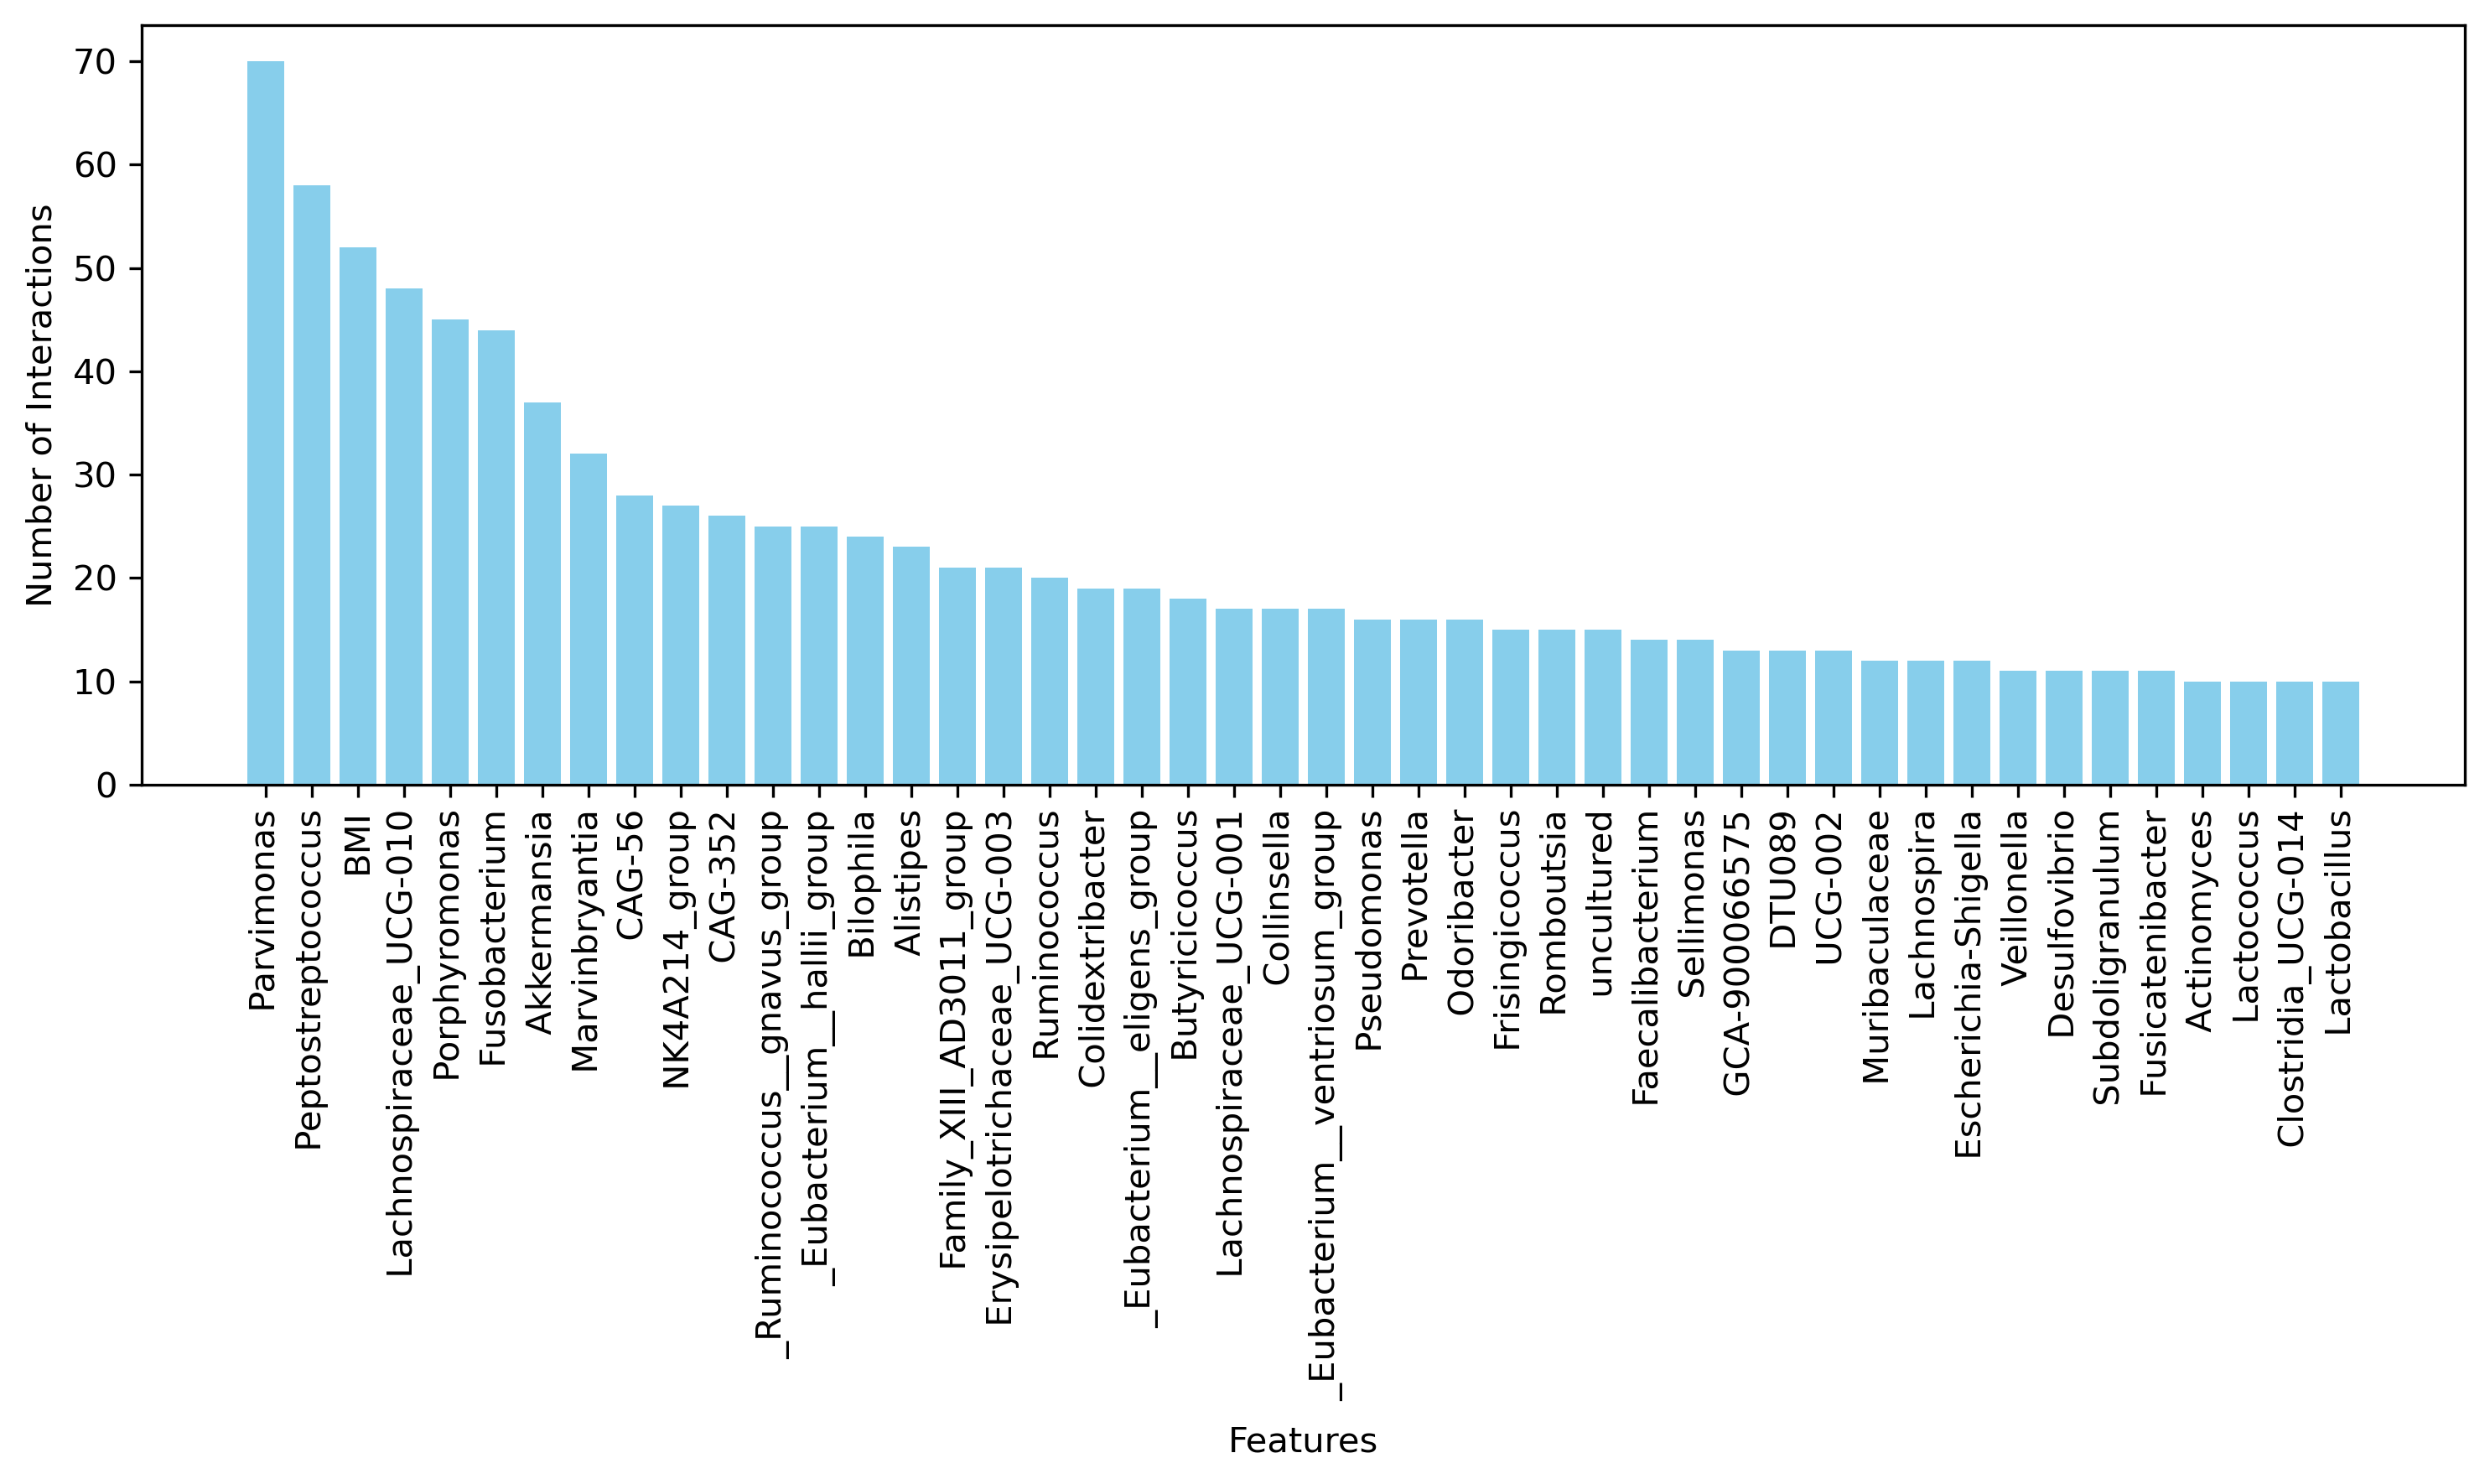

In [54]:
# Prepare the filtered interaction counts DataFrame
filtered_interaction_counts_df = (
    filtered_interaction_counts_final
    .reset_index(name='Count')
    .rename(columns={'index': 'Feature'})
)

# Plot the histogram of the 'Count' column
plt.figure(figsize=(10, 6),dpi=300)
plt.bar(
    filtered_interaction_counts_df['Feature'], 
    filtered_interaction_counts_df['Count'], 
    color='skyblue'
)
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Number of Interactions")
plt.title("")
plt.tight_layout()
plt.show()

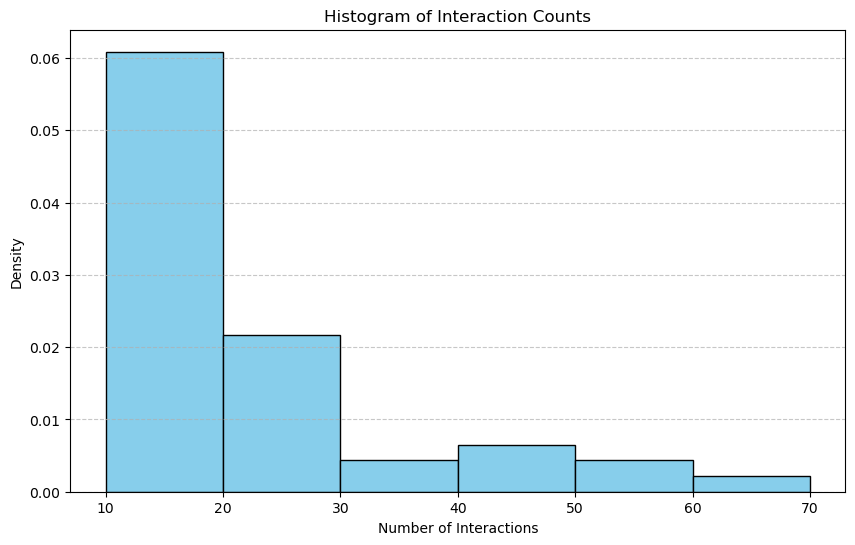

In [55]:
# Plotting the histogram of the 'Count' column
plt.figure(figsize=(10, 6))
plt.hist(filtered_interaction_counts_df['Count'], bins=6, color='skyblue', density =True,edgecolor='black')
plt.xlabel("Number of Interactions")
plt.ylabel("Density")
plt.title("Histogram of Interaction Counts")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [56]:
# Selezione del 95° percentile del dataframe basandosi sulla colonna 'Interaction'
threshold_95 = shap_long['Interaction'].quantile(0.95)
shap_long_95_percentile = shap_long[shap_long['Interaction'] >= threshold_95]
shap_long_95_percentile

,Feature1,Feature2,Interaction
0,Sellimonas,Lachnospiraceae_UCG-010,0.004876
1,Muribaculaceae,Lachnospiraceae_UCG-001,0.002535
2,Alistipes,BMI,0.002265
3,Fusobacterium,Romboutsia,0.002265
4,Porphyromonas,Lachnospiraceae_UCG-010,0.002088
...,...,...,...
714,Fusicatenibacter,Anaerofilum,0.000483
715,Bacteroides,Marvinbryantia,0.000483
716,_Ruminococcus__gnavus_group,Lachnospiraceae_UCG-010,0.000483
717,Fusobacterium,Lachnospiraceae_UCG-008,0.000483


In [57]:
# Calcolare il numero di interazioni sopra il 95° percentile per ciascuna feature
# Combinare le colonne Feature1 e Feature2 in un unico array, poi contare le occorrenze
interaction_counts = pd.concat([
    shap_long_95_percentile['Feature1'], 
    shap_long_95_percentile['Feature2']
]).value_counts()

# Convertire in un DataFrame per una rappresentazione più leggibile
interaction_counts_df = interaction_counts.reset_index()
interaction_counts_df.columns = ['Feature', 'Count']

# Ordinare il DataFrame in base al numero di interazioni
interaction_counts_df = interaction_counts_df.sort_values(by='Count', ascending=False)

# Mostrare i risultati
print(interaction_counts_df)

                      Feature  Count
0                  Parvimonas     70
1          Peptostreptococcus     58
2                         BMI     52
3     Lachnospiraceae_UCG-010     48
4               Porphyromonas     45
..                        ...    ...
133              Holdemanella      1
132           Catenibacterium      1
131               Allisonella      1
130                Paracoccus      1
150                    DTU014      1

[151 rows x 2 columns]


In [58]:
# Definire una soglia minima di interazioni
interaction_threshold = 10

# Filtrare il DataFrame per mantenere solo le righe che superano la soglia
filtered_interaction_counts_df = interaction_counts_df[interaction_counts_df['Count'] >= interaction_threshold]

# Mostrare il sotto-DataFrame
print(filtered_interaction_counts_df)

                            Feature  Count
0                        Parvimonas     70
1                Peptostreptococcus     58
2                               BMI     52
3           Lachnospiraceae_UCG-010     48
4                     Porphyromonas     45
5                     Fusobacterium     44
6                       Akkermansia     37
7                    Marvinbryantia     32
8                            CAG-56     28
9                     NK4A214_group     27
10                          CAG-352     26
11      _Ruminococcus__gnavus_group     25
12       _Eubacterium__hallii_group     25
13                        Bilophila     24
14                        Alistipes     23
15         Family_XIII_AD3011_group     21
16      Erysipelotrichaceae_UCG-003     21
17                     Ruminococcus     20
19      _Eubacterium__eligens_group     19
18                 Colidextribacter     19
20                   Butyricicoccus     18
21          Lachnospiraceae_UCG-001     17
22         

In [59]:
# Definire una soglia minima di interazioni
interaction_threshold = 10

# Filtrare le feature che superano la soglia
features_above_threshold = interaction_counts_df[interaction_counts_df['Count'] >= interaction_threshold]['Feature']

# Creare un sotto-dataframe che contiene solo le interazioni tra queste feature
filtered_shap_long = shap_long_95_percentile[
    (shap_long_95_percentile['Feature1'].isin(features_above_threshold)) &
    (shap_long_95_percentile['Feature2'].isin(features_above_threshold))
].reset_index(drop=True)

# Mostrare il sotto-dataframe
filtered_shap_long

,Feature1,Feature2,Interaction
0,Sellimonas,Lachnospiraceae_UCG-010,0.004876
1,Muribaculaceae,Lachnospiraceae_UCG-001,0.002535
2,Alistipes,BMI,0.002265
3,Fusobacterium,Romboutsia,0.002265
4,Porphyromonas,Lachnospiraceae_UCG-010,0.002088
...,...,...,...
317,GCA-900066575,BMI,0.000484
318,Collinsella,Lactococcus,0.000484
319,Clostridia_UCG-014,GCA-900066575,0.000483
320,_Ruminococcus__gnavus_group,Lachnospiraceae_UCG-010,0.000483


In [60]:
import networkx as nx
# Ensure 'Count' is numeric
filtered_interaction_counts_df['Count'] = pd.to_numeric(filtered_interaction_counts_df['Count'], errors='coerce')

# Check if there are any NaN values
if filtered_interaction_counts_df['Count'].isna().any():
    print("Found NaN values in 'Count'. Dropping these rows.")
    filtered_interaction_counts_df = filtered_interaction_counts_df.dropna(subset=['Count'])

# Convert 'Count' to integer type
filtered_interaction_counts_df['Count'] = filtered_interaction_counts_df['Count'].astype(int)

# Define size classes and assign sizes
size_classes = [100, 250, 500, 1000]  # Adjust node size ranges for visualization
filtered_interaction_counts_df['Size'] = pd.cut(
    filtered_interaction_counts_df['Count'].values, 
    bins=4, 
    labels=size_classes
)

# Build the graph
G = nx.Graph()

# Add nodes with size (proportional to 'Count')
for _, row in filtered_interaction_counts_df.iterrows():
    G.add_node(row['Feature'], size=int(row['Size']))

# Add edges with weights
for _, row in filtered_shap_long.iterrows():
    G.add_edge(row['Feature1'], row['Feature2'], weight=row['Interaction'])

/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_17743/3791231091.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interaction_counts_df['Count'] = pd.to_numeric(filtered_interaction_counts_df['Count'], errors='coerce')
/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_17743/3791231091.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_interaction_counts_df['Count'] = filtered_interaction_counts_df['Count'].astype(int)
/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/

In [61]:
# Save the edges dataframe with source, target, and weight
edges_df = filtered_shap_long[['Feature1', 'Feature2', 'Interaction']].rename(
    columns={'Feature1': 'Source', 'Feature2': 'Target', 'Interaction': 'Weight'}
)
edges_df.to_csv("edges_cluster6.csv", index=False)

In [64]:
# Calcolare varie metriche per la rete pesata
degree = dict(G.degree(weight='weight'))
betweenness = nx.betweenness_centrality(G, weight='weight')
closeness = nx.closeness_centrality(G, distance='weight')
eigenvector = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
pagerank = nx.pagerank(G, weight='weight')

# Creare un dataframe per analizzare i risultati
import pandas as pd
metrics_df = pd.DataFrame({
    'Degree': degree,
    'Betweenness': betweenness,
    'Closeness': closeness,
    'Eigenvector': eigenvector,
    'PageRank': pagerank
})

# Ordinare i nodi in base alla metrica desiderata (es. PageRank)
metrics_df = metrics_df.sort_values(by='Eigenvector', ascending=False)
print(metrics_df.head(10))  # Top 10 nodi

                            Degree  Betweenness    Closeness  Eigenvector  \
 Lachnospiraceae_UCG-010  0.027222     0.048485  1161.985403     0.357713   
BMI                       0.023762     0.061616  1211.478117     0.294238   
 Peptostreptococcus       0.024381     0.036364  1193.493368     0.268710   
 Porphyromonas            0.019126     0.052525  1220.367331     0.253489   
 Parvimonas               0.021605     0.076768  1300.039233     0.243302   
 Sellimonas               0.012128     0.006061   916.365346     0.234905   
 Fusobacterium            0.020478     0.040404  1137.094759     0.231768   
 Akkermansia              0.018592     0.087879  1216.336453     0.214754   
 Alistipes                0.012191     0.022222  1085.903303     0.184599   
 Odoribacter              0.009152     0.010101  1009.120120     0.163367   

                          PageRank  
 Lachnospiraceae_UCG-010  0.052277  
BMI                       0.046258  
 Peptostreptococcus       0.048534  
 Por

In [65]:
# Map the number of interactions to each node from 'filtered_interaction_counts_df'
interaction_counts_dict = dict(filtered_interaction_counts_df.set_index('Feature')['Count'])

# Add the number of interactions to the metrics DataFrame
metrics_df['Interactions'] = metrics_df.index.map(interaction_counts_dict)

# Replace NaN with 0 for nodes that might not have interaction counts
metrics_df['Interactions'] = metrics_df['Interactions'].fillna(0).astype(int)

# Sort the dataframe by a selected metric (e.g., Eigenvector centrality)
metrics_df = metrics_df.sort_values(by='Interactions', ascending=False)

# Display the top 10 nodes
print(metrics_df.head(10))

                            Degree  Betweenness    Closeness  Eigenvector  \
 Parvimonas               0.021605     0.076768  1300.039233     0.243302   
 Peptostreptococcus       0.024381     0.036364  1193.493368     0.268710   
BMI                       0.023762     0.061616  1211.478117     0.294238   
 Lachnospiraceae_UCG-010  0.027222     0.048485  1161.985403     0.357713   
 Porphyromonas            0.019126     0.052525  1220.367331     0.253489   
 Fusobacterium            0.020478     0.040404  1137.094759     0.231768   
 Akkermansia              0.018592     0.087879  1216.336453     0.214754   
 Marvinbryantia           0.013461     0.016162  1054.944350     0.145926   
 CAG-56                   0.011750     0.022222  1059.694261     0.152560   
 NK4A214_group            0.011158     0.014141  1033.446732     0.160546   

                          PageRank  Interactions  
 Parvimonas               0.043051            70  
 Peptostreptococcus       0.048534            58  

In [66]:
import igraph as ig


# Convert the NetworkX graph to an igraph object
igraph_graph = ig.Graph.from_networkx(G)

# Ensure that the node names in igraph correspond to the node IDs in the NetworkX graph
igraph_graph.vs["name"] = list(G.nodes())

# Perform Leiden community detection for 500 iterations with varying seeds
partitions = {}
for s in range(500):
    np.random.seed(s)
    my_part = igraph_graph.community_leiden(
        objective_function="modularity",
        weights=igraph_graph.es["weight"],
        resolution_parameter=1.0,
        beta=0.01
    )
    partitions[s] = my_part.membership

# Find the most common partition
unique_partitions, counts = np.unique([partitions[i] for i in range(500)], return_counts=True, axis=0)
most_common_partition_index = np.argmax(counts)
most_common_partition = unique_partitions[most_common_partition_index]

# Align the partition to the correct order of nodes in metrics_df
igraph_node_order = list(igraph_graph.vs["name"])  # Names of nodes in igraph
aligned_partition = [most_common_partition[igraph_node_order.index(node)] for node in metrics_df.index]

# Add the aligned partition as the 'Community' column in metrics_df
metrics_df["Community"] = aligned_partition

# Save the nodes dataframe for Gephi
nodes_gephi = metrics_df.copy()
nodes_gephi.reset_index(inplace=True)
nodes_gephi.rename(columns={"index": "Id"}, inplace=True)  # Rename the index column to 'Id' for Gephi
nodes_gephi.to_csv("nodes_for_gephi_cluster6.csv", index=False)

# Calculate the modularity of the most common partition
modularity = igraph_graph.modularity(most_common_partition, weights=igraph_graph.es["weight"])
print(f"Modularity of the most common partition: {modularity}")


# Save the communities and modularity metrics
id_communities, card_communities = np.unique(most_common_partition, return_counts=True)
communities_summary = {
    "Community ID": id_communities,
    "Size": card_communities,
}
communities_summary_df = pd.DataFrame(communities_summary)
communities_summary_df.to_csv("communities_summary_cluster6.csv", index=False)

# Outputs
print("Nodes for Gephi saved to 'nodes_for_gephi_cluster6.csv'.")
print("Communities summary saved to 'communities_summary_cluster6.csv'.")
print(f"Modularity: {modularity}")

Modularity of the most common partition: 0.188253771110289
Nodes for Gephi saved to 'nodes_for_gephi_cluster6.csv'.
Communities summary saved to 'communities_summary_cluster6.csv'.
Modularity: 0.188253771110289


/var/folders/33/yp65m1l108jcjptn6hq_l35h0000gn/T/ipykernel_17743/2521469897.py:14: DeprecationWarning: resolution_parameter keyword argument is deprecated, use resolution=... instead
  my_part = igraph_graph.community_leiden(
